In [1]:
#pip list

In [1]:
# pip install hyperopt phik

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import time
import re
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sb
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats as st
import copy
from datetime import datetime
from scipy.stats import chi2_contingency, fisher_exact, pointbiserialr
from tqdm.notebook import tqdm

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
random_state = 290822

<h1>Содержание<span class="tocSkip"></span></h1>
<a id='contents'></a>

- [I. Техническое задание](#intro) 
- [II. Обзор и обработка данных](#review&prepare)
    - [1. Первичный обзор](#first_review)
    - [2. Анализ данных](#analisys)
    - [3. Исследование данных](#research) 
    - [4. Сплит данных на выборки](#split_data)
    - [5. Анализ выброса признака: длительность клиентства](#hitch)    
    - [6. Выбор признаков](#features)
    - [Выводы аналитической части](#review_summary)
- [III. Построение моделей](#models)
    - [1. Модель «Случайный лес»](#forest)
    - [2. Модель «Логистическая регрессия»](#regression)
    - [3. Модель LightGBM](#lgbm)    
    - [4. Модель XGBoost](#xgboost)
    - [5. Выбор лучшей модели и проверка на тестовой выборке](#test)
    - [6. Проверка модели на вменяемость](#aruok?)
    - [Выводы раздела построения моделей](#models_summary) 
- [IV. Итоги исследования](#final_summary)
- [V. Отчет по проекту](#report)

<a id='intro'></a>
# I. Техническое задание

## Определение потенциально уходящего клиента телеком-компании <a class="tocSkip">

**Заказчик** — оператор связи «Ниединогоразрыва.ком».

**Цель исследования**:
1. Научиться на основании клиентской базы оператора определять потенциально уходящего клиента.

**Поставленные задачи**
1. Изучить предоставленную базу данных клиентов и модели их потребительского поведения.
2. Выявить основные признаки, влияющие на отток клиентов. Создать дополнительные признаки на основании предоставленных данных, способствувющих обучению моделей.
3. Подготовить данные для обучения моделей.
4. Обучить разные модели и найти лучшую с предельно большим значением метрики AUC-ROC. 
5. Проверить качество выбранной модели на тестовой выборке размером 25% от исходных данных.
6. Резюмировать анализ и выбрать лучшее решение/модель для бизнеса, которое следует использовать для предсказания ухода клиентов. Также выявить закономерности между признаками по моделям потребительского поведения клиентов для предоставления им дополнительных услуг.

**Дальнейшее использование**

Результаты исследования будут использоваться в дальнейшем при планировании стратегии мотивации клиента передумать, предложив ему промокоды и специальные условия.

**Дополнительно предоставленная инфомарция**

***Описание оновных услуг:***

1. Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

***Описание дополнительных услуг:***

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

***Условия оплаты***

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## База данных <a class="tocSkip">

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

[К оглавлению](#contents)

<a id='review&prepare'></a>
# II. Обзор и обработка данных

<a id='first_review'></a>
## 1. Первичный обзор

Сначала составим представление о полученных исходных данных.

Прочитаем исходные файлы с данными клиентов `contract.csv`, `personal.csv`, `internet.csv`, `phone.csv` из папки `/datasets/` и сохраним их в одноименные переменные:

In [3]:
def open_csv_file(file_name, spreadsheet_id=''):
    pth1 = 'D:/Programs/Jupyter_projects/datasets/final_provider/' + file_name + '.csv'
    pth2 = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    pth3 = '/datasets/' + file_name + '.csv'


    if os.path.exists(pth1):
        df = pd.read_csv(pth1, parse_dates = [0])
    elif spreadsheet_id != '':
        r = requests.get(pth2)
        df = pd.read_csv(BytesIO(r.content))
    elif os.path.exists(pth3):
        df = pd.read_csv(pth3, parse_dates = [0])

    else:
        print('Something is wrong')
    return df

In [4]:
contract = open_csv_file('contract', '1asMCDEb7p_6Ou_u9KaomlouX7HwEaeuxwcDhqLHttz8')
personal = open_csv_file('personal', '15owR0bpQLAhgomGl2qsP6U75qMjEBAL7yN3PBhEA4oI')
internet = open_csv_file('internet', '1cvvEWZ8sVgK34p2j8F61QKY0F8NPRUsD9VtZKYrMojU') 
phone = open_csv_file('phone', '1GhZ_4lLJXHrNU7nGW4ieEerqO846bC2MIAuUsoZ62cE')

#сохраним все в единую пемеренную `df`:
df = {
    'contract': contract,
    'personal': personal, 
    'internet': internet,
    'phone': phone
}

Сразу приведем названия признаков к единому стилю

In [5]:
for data in df:
    df.get(data).columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in df.get(data).columns]
    df.get(data).rename(columns={'customer_i_d': 'customer_id', 'streaming_t_v': 'streaming_tv'}, inplace=True) 

Выведем на экран первые пять строк таблиц:

In [6]:
for data in df:
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(data))
    display(df.get(data).head())
    print('_' * 120)


	contract


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 0:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 0:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


________________________________________________________________________________________________________________________

	personal


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


________________________________________________________________________________________________________________________

	internet


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


________________________________________________________________________________________________________________________

	phone


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


________________________________________________________________________________________________________________________


И получим общую информацию:

In [7]:
for data in df:
    print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format(data), '\n')
    display(df.get(data).info())
    print('*' * 50)

		contract 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


None

**************************************************
		personal 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

**************************************************
		internet 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

**************************************************
		phone 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

**************************************************


Итак, мы имеем следующие данные и информацию о них согласно исходной документации: 
    
**1. Таблица `contract` (информация о договоре):** 

* `customer_id` — уникальный идентификатор клиента
* `begin_date`— дата заключения контракта / дата начала пользования услугами
* `end_date` — дата расторжения контракта / дата окончания пользования услугами
* `type` — тип оплаты: ежемесячный, годовой
* `paperless_billing` — безналичный расчет
* `payment_method` — способ оплаты
* `monthly_charges` — ежемесячные траты на услуги
* `total_charges` — общая уплаченная сумма с момента заключения договора / всего потрачено денег на услуги

Типы данных в столбцах — вещественные числа `float` и строки `object`.

**2. Таблица `personal` (информация о клиентах):** 

* `customer_id` — уникальный идентификатор клиента
* `gender` — пол клиента
* `senior_citizen` — наличие пенсионного статуса по возрасту
* `partner` — наличие супруга(и)
* `dependents` — наличие иждивенцев

Типы данных в столбцах — целые числа `int`,  и строки `object`.

**3. Таблица `internet` (информация об интернет-услугах):**

* `customer_id` — уникальный идентификатор клиента
* `internet_service` — способ подключения интернета
* `online_security` — дополнительная услуга «Блокировка небезопасных сайтов»
* `online_backup` — дополнительная услуга «Облачное хранилище файлов для резервного копирования данных»
* `device_protection` — дополнительная услуга «Антивирус»
* `tech_support` — дополнительная услуга «Выделенная линия технической поддержки»
* `streaming_tv` — дополнительная услуга «Стриминговое телевидение»
* `streaming_movies` — дополнительная услуга «Каталог фильмов»

Типы данных в столбцах — строки `object`.

**4. Таблица `phone` (информация об услугах телефонии):**

* `customer_id` — уникальный идентификатор клиента
* `multiple_lines` — дополнительная услуга «Подключение телефонного аппарата к нескольким линиям одновременно»

Типы данных в столбцах — строки `object`.

Среди всех датасетов в глаза бросается сразу:
- неравное количество значений в `contract`, `phone` и `internet`, это можно объяснить тем, что в базе данных по клиентам не все пользуются и телефонной связью, и интернетом одновременно у конкретного оператора;
- явных пропусков не наблюдается;
- разное количество предоставленной информации по пользователям (в каждом датасете, за исключением данных и тарифах, есть уникальный идентификатор пользователя);
- в таблице `calls` столбцы `begin_date` и `end_date` имеют неверный формат.
    
**Для второго разночтения будем придерживаться следующей логики:**
* <span style="color: #4682B4; font-weight: 600"> Некоторые клиенты пользовались не всеми услугами: кто-то только звонками (подавляющее большинство значений).</span>

В последующем для анализа нам потребуется объединить данные из нескольких датасетов для создания выборки и проведения исследования, поэтому **образовавшиеся в процессе слияния пропуски мы заполним нулями**, основываясь принятой логике. 

Названия колонок приведены к единому стилю.

[К оглавлению](#contents)

<a id='analisys'></a>
## 2. Анализ данных

### 2.1 Обработка данных

В датафрейме `contract` указана информация о **дате прекращения действия контракта / дате прекращения пользования услугами** - что будет указывать нам на факт ухода клиента. Однако с датами мы работать в обучении модели не будем, поэтому добавим столбец с целочисленными значениями, соответствующей бинарной классификации, по следующей логике:
- 0 - `клиент не ушел`
- 1 - `клиент расторгнул договор`

In [8]:
df.get('contract')['client_left'] = df.get('contract')['end_date'].apply(lambda x: 1 if x != 'No' else 0)
df.get('contract')['client_left'].value_counts()

0    5174
1    1869
Name: client_left, dtype: int64

**Также мы сразу видим имеющийся дисбаланс классов, который необходимо будет в дальнейшем сбалансировать для лучшего обучения наших моделей.**

Помимо этого добавим к нашей таблице время в днях, показывающее сколько дней люди оставались клиентами нашей компании. Для этого сперва выполним преобразование типов данных, ранее поставленным задачам: переведем столбцы с датами `begin_date`, `end_date` с типа `object` на `datetime`.

***Перед этим поставим заглушку `2020-02-01` вместо `No` в признаке даты разрыва контракта*** для корректного преобразования для на момент выгрузки базы данных

In [9]:
df.get('contract').loc[df.get('contract')['end_date'] == 'No', 'end_date'] = '2020-02-01'
df.get('contract')['end_date'].max() # проверим, что заглушка не выходит за рамки временного промежутка

'2020-02-01'

In [10]:
col = {'begin_date':df.get('contract'),
       'end_date':df.get('contract')
      }

for _, data in col.items():
    data[_] = pd.to_datetime(data[_],format = '%Y-%m-%d')

In [11]:
df.get('contract').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   client_left        7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


Теперь добавим к нашей таблице время в днях, показывающее сколько дней люди оставались клиентами нашей компании

In [12]:
df.get('contract')['time_interval'] = (df.get('contract')['end_date'] - df.get('contract')['begin_date']).dt.days

In [13]:
df.get('contract').head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left,time_interval
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


### 2.2. Пропуски

Еще раз посмотрим на наличие явных пропусков

In [14]:
for data in df:
    print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format(data), '\n')
    i = 0
    for column in list(df.get(data).columns):
        if len(df.get(data)[df.get(data)[column].isna()]) > 0:
            print('Количество пропусков в столбце \033[4m\033[1m\033[31m{}\033[0m:'.format(column), len(df.get(data)[df.get(data)[column].isna()]))
            k = len(df.get(data)[df.get(data)[column].isna()]) / df.get(data).shape[0]
            print(f'Таким образом доля незаполненных данных составляет: {k:.2%}\n')
            i = 1
        if i == 0:
            print('Пропусков нет!')
    print('*' * 30)

		contract 

Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Количество пропусков в столбце total_charges: 11
Таким образом доля незаполненных данных составляет: 0.16%

******************************
		personal 

Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
******************************
		internet 

Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
Пропусков нет!
******************************
		phone 

Пропусков нет!
Пропусков нет!
******************************


### 2.3. Проверка явных дубликатов

In [15]:
for data in df:
    print(f'Дубликатов в \033[4m\033[1m\033[31m{data}\033[0m:', df.get(data).duplicated().sum())
    print('-' * 25)

Дубликатов в contract: 0
-------------------------
Дубликатов в personal: 0
-------------------------
Дубликатов в internet: 0
-------------------------
Дубликатов в phone: 0
-------------------------


### 2.4 Категоризация признаков

In [16]:
for data in df:
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(data))
    display(df.get(data).head(2))
    print('_' * 120)


	contract


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left,time_interval
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036


________________________________________________________________________________________________________________________

	personal


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


________________________________________________________________________________________________________________________

	internet


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


________________________________________________________________________________________________________________________

	phone


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No


________________________________________________________________________________________________________________________


У нас есть признаки представленных в виде строк, которые модели не смогут переварить. Заранее посмотрели уникальные значения столбцов. Поэтому применим метод OHE для:
- Варианты `Yes` и `No`:
    - `multiple_lines`, 
    - `paperless_billing`, 
    - `partner`, 
    - `dependents`, 
    - `online_security`, 
    - `online_backup`, 
    - `device_protection`, 
    - `tech_support`, 
    - `streaming_tv`, 
    - `streaming_movies`.
- Варианты `Female` и `Male`: 
    - `gender`

In [17]:
# для таблицы phone с апдейтом словаря
new_temp = pd.get_dummies(df.get('phone'), columns=['multiple_lines'], drop_first=True)
df.update({'phone': new_temp})

# для таблицы internet с апдейтом словаря
new_temp = pd.get_dummies(df.get('internet'), columns=['online_security', 'online_backup', 
                                                       'device_protection', 'tech_support', 
                                                       'streaming_tv', 'streaming_movies'], 
                          drop_first=True)
df.update({'internet': new_temp})

# для таблицы personal с апдейтом словаря
new_temp = pd.get_dummies(df.get('personal'), columns=['gender', 'partner', 'dependents'], 
                          drop_first=True)
df.update({'personal': new_temp})

# для таблицы contract с апдейтом словаря
new_temp = pd.get_dummies(df.get('contract'), columns=['paperless_billing'], 
                          drop_first=True)
df.update({'contract': new_temp})

pass

In [18]:
for data in df:
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(data))
    display(df.get(data).head(1))
    print('_' * 120)


	contract


,customer_id,begin_date,end_date,type,payment_method,monthly_charges,total_charges,client_left,time_interval,paperless_billing_Yes
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Electronic check,29.85,29.85,0,31,1


________________________________________________________________________________________________________________________

	personal


,customer_id,senior_citizen,gender_Male,partner_Yes,dependents_Yes
0,7590-VHVEG,0,0,1,0


________________________________________________________________________________________________________________________

	internet


,customer_id,internet_service,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes
0,7590-VHVEG,DSL,0,1,0,0,0,0


________________________________________________________________________________________________________________________

	phone


,customer_id,multiple_lines_Yes
0,5575-GNVDE,0


________________________________________________________________________________________________________________________


Второй тип проблемных признаков - это множественные типы. Воспользуемся порядковым кодированием для присвоения лэйбла каждому типу. И выведем их
- `internet_service` : DSL и Fiber optic
- `type` : Month-to-month, One year, Two year`
- `payment_method` : Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)

In [19]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df.get('internet')[['internet_service']]), columns=['internet_service_label'])

encoder.categories_

[array(['DSL', 'Fiber optic'], dtype=object)]

Маркеры присвоены соответственно: DSL = 0, Fiber optic = 1

In [20]:
new_temp = (pd.concat([df.get('internet'),df_ordinal],sort=False,axis=1) # присоединим преобразованный столбец
      .reindex(columns=['customer_id', 'internet_service', 'internet_service_label', 
                        'online_security_Yes', 'online_backup_Yes', 
                        'device_protection_Yes', 'tech_support_Yes',
                        'streaming_tv_Yes', 'streaming_movies_Yes'])
)

df.update({'internet': new_temp})

In [21]:
df.get('internet').head(2)

,customer_id,internet_service,internet_service_label,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes
0,7590-VHVEG,DSL,0.0,0,1,0,0,0,0
1,5575-GNVDE,DSL,0.0,1,0,1,0,0,0


In [22]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df.get('contract')[['type', 'payment_method']]), columns=['type_label', 'payment_method_label'])

encoder.categories_

[array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

Маркеры присвоены соответственно: 
- Month-to-month = 0, One year = 1, Two year = 2
- Bank transfer (automatic) = 0, Credit card (automatic) = 1, Electronic check = 2, Mailed check = 3

In [23]:
new_temp = (pd.concat([df.get('contract'),df_ordinal],sort=False,axis=1) # присоединим преобразованный столбец
      .reindex(columns=['customer_id', 'begin_date', 'end_date', 'type', 'type_label', 
                        'payment_method', 'payment_method_label',
                        'monthly_charges', 'total_charges', 'client_left', 
                        'time_interval', 'paperless_billing_Yes'])
)

df.update({'contract': new_temp})

Объединим получившиеся таблицы в одну, но прежде: добавим в таблицы интернета и телефонной связи колонки с признаком факта подключения данной услуги

In [24]:
df.get('internet')['internet_client_yes'] = 1
df.get('phone')['phone_client_yes'] = 1

In [25]:
all_services = (df.get('contract')
                .merge(df.get('personal'),
                       how='outer', 
                       on=['customer_id'])
                .merge(df.get('internet'), 
                       how='outer', 
                       on=['customer_id'])
                .merge(df.get('phone'), 
                       how='outer', 
                       on=['customer_id'])
               )
all_services.columns = all_services.columns.str.lower()
all_services.head(3)

,customer_id,begin_date,end_date,type,type_label,payment_method,payment_method_label,monthly_charges,total_charges,client_left,...,internet_service_label,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,internet_client_yes,multiple_lines_yes,phone_client_yes
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,0.0,Electronic check,2.0,29.85,29.85,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,1.0,Mailed check,3.0,56.95,1889.50,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,0.0,Mailed check,3.0,53.85,108.15,1,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [26]:
all_services.shape[0]

7043

Количество записей у нас соответствует количеству зарегистрированных пользователей 7043.

Заодно посчитаем, при первичном обзоре заметил, что некоторые клиенты оформили договор на услуги именно в месяц выгрузки баз данных, а именно 1 февраля 2020, что означает, что в дальнейшем они будут вносить хаос в нашу статистику и оценить их полезность будет проблематично - о их дальнейших действиях на текущий момент нет никакой информации: будут они уходить или нет. 

In [27]:
all_services[(all_services['client_left'] == 0) &
             (all_services['begin_date'] == '2020-02-01') &
             (all_services['end_date'] == '2020-02-01')]

,customer_id,begin_date,end_date,type,type_label,payment_method,payment_method_label,monthly_charges,total_charges,client_left,...,internet_service_label,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,internet_client_yes,multiple_lines_yes,phone_client_yes
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,2.0,Bank transfer (automatic),0.0,52.55,NaN,0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,2.0,Mailed check,3.0,20.25,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,2.0,Mailed check,3.0,80.85,NaN,0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,2.0,Mailed check,3.0,25.75,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,2.0,Credit card (automatic),1.0,56.05,NaN,0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,2.0,Mailed check,3.0,19.85,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,2.0,Mailed check,3.0,25.35,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,2.0,Mailed check,3.0,20.00,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1.0,Mailed check,3.0,19.70,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,2.0,Mailed check,3.0,73.35,NaN,0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


Еще раз убедились, что они есть.

In [28]:
__ = all_services[(all_services['client_left'] == 0) &
             (all_services['begin_date'] == '2020-02-01') &
             (all_services['end_date'] == '2020-02-01')].index

print('Количество оставшихся клиентов, оформивших услуги в месяц выгрузки базы данных: {} человек, что составляет {}% от общего числа клиентов'
      .format(len(__), round(len(__) / len(all_services['customer_id']) * 100, 2)))

Количество оставшихся клиентов, оформивших услуги в месяц выгрузки базы данных: 11 человек, что составляет 0.16% от общего числа клиентов


In [29]:
_ = all_services[(all_services['client_left'] == 1) &
             (all_services['begin_date'] == '2020-02-01') &
             (all_services['end_date'] == '2020-02-01')]['customer_id']

print('Количество ушедших клиентов, оформивших услуги в месяц выгрузки базы данных: {} человек, что составляет {}% от общего числа клиентов'
      .format(_.count(), round(_.count() / len(all_services['customer_id']) * 100, 2)))

Количество ушедших клиентов, оформивших услуги в месяц выгрузки базы данных: 0 человек, что составляет 0.0% от общего числа клиентов


Таким образом получается, что в нашей базе есть 11 записей о людях, оформивших договор с компанией в месяц выгрузки БД, их вклад незначительный, поэтому считаю, что можно без промедления избавиться от них, дабы улучшить метрику наших моделей и не предоставлять на обучение данные с неисзвестным исходом.

In [30]:
print('Количество строк до дропа:', all_services.shape[0])
all_services.drop(labels = list(__),axis = 0, inplace = True)
print('Количество строк после дропа:', all_services.shape[0])

Количество строк до дропа: 7043
Количество строк после дропа: 7032


Теперь, благодаря тому, что мы ранее добавили в таблицы `internet` и `phone` факт использования клиентами того или иного типа основных услуг, мы можем заполнить образовавшиеся пустоты / пропуски NaN нулями не боясь в последствии неверно интерпретировать данные при исследовании.

In [31]:
all_services = all_services.fillna(value = 0)

И скорректируем тип данных в `total_charges`

In [32]:
all_services['total_charges'] = all_services['total_charges'].astype('float')

list_to_int = ['type_label', 'payment_method_label', 'paperless_billing_yes', 
               'gender_male', 'partner_yes', 'dependents_yes', 
               'internet_service_label', 'online_security_yes', 
               'online_backup_yes', 'device_protection_yes',
               'tech_support_yes', 'streaming_tv_yes', 'streaming_movies_yes',
               'internet_client_yes', 'multiple_lines_yes', 'phone_client_yes']

all_services[list_to_int] = all_services[list_to_int].astype('int')

all_services.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7032 non-null   object        
 1   begin_date              7032 non-null   datetime64[ns]
 2   end_date                7032 non-null   datetime64[ns]
 3   type                    7032 non-null   object        
 4   type_label              7032 non-null   int64         
 5   payment_method          7032 non-null   object        
 6   payment_method_label    7032 non-null   int64         
 7   monthly_charges         7032 non-null   float64       
 8   total_charges           7032 non-null   float64       
 9   client_left             7032 non-null   int64         
 10  time_interval           7032 non-null   int64         
 11  paperless_billing_yes   7032 non-null   int64         
 12  senior_citizen          7032 non-null   int64   

<a id='research'></a>
## 3. Исследовательский анализ

### 1. Корреляция и начальное исследование признаков

Посмотрим на распределение признаков, от которых будет зависеть уход клиента. Исключим сразу профильные данные и дублирующие признаки: уникальный номер клиента, даты подписания и разрыва контракта, способ оплаты, способ подключения интернета и целевой признак.

array([[<AxesSubplot:title={'center':'type_label'}>,
        <AxesSubplot:title={'center':'streaming_tv_yes'}>,
        <AxesSubplot:title={'center':'total_charges'}>,
        <AxesSubplot:title={'center':'monthly_charges'}>],
       [<AxesSubplot:title={'center':'streaming_movies_yes'}>,
        <AxesSubplot:title={'center':'internet_client_yes'}>,
        <AxesSubplot:title={'center':'paperless_billing_yes'}>,
        <AxesSubplot:title={'center':'device_protection_yes'}>],
       [<AxesSubplot:title={'center':'online_backup_yes'}>,
        <AxesSubplot:title={'center':'phone_client_yes'}>,
        <AxesSubplot:title={'center':'online_security_yes'}>,
        <AxesSubplot:title={'center':'dependents_yes'}>],
       [<AxesSubplot:title={'center':'partner_yes'}>,
        <AxesSubplot:title={'center':'senior_citizen'}>,
        <AxesSubplot:title={'center':'multiple_lines_yes'}>,
        <AxesSubplot:title={'center':'tech_support_yes'}>],
       [<AxesSubplot:title={'center':'gender_mal

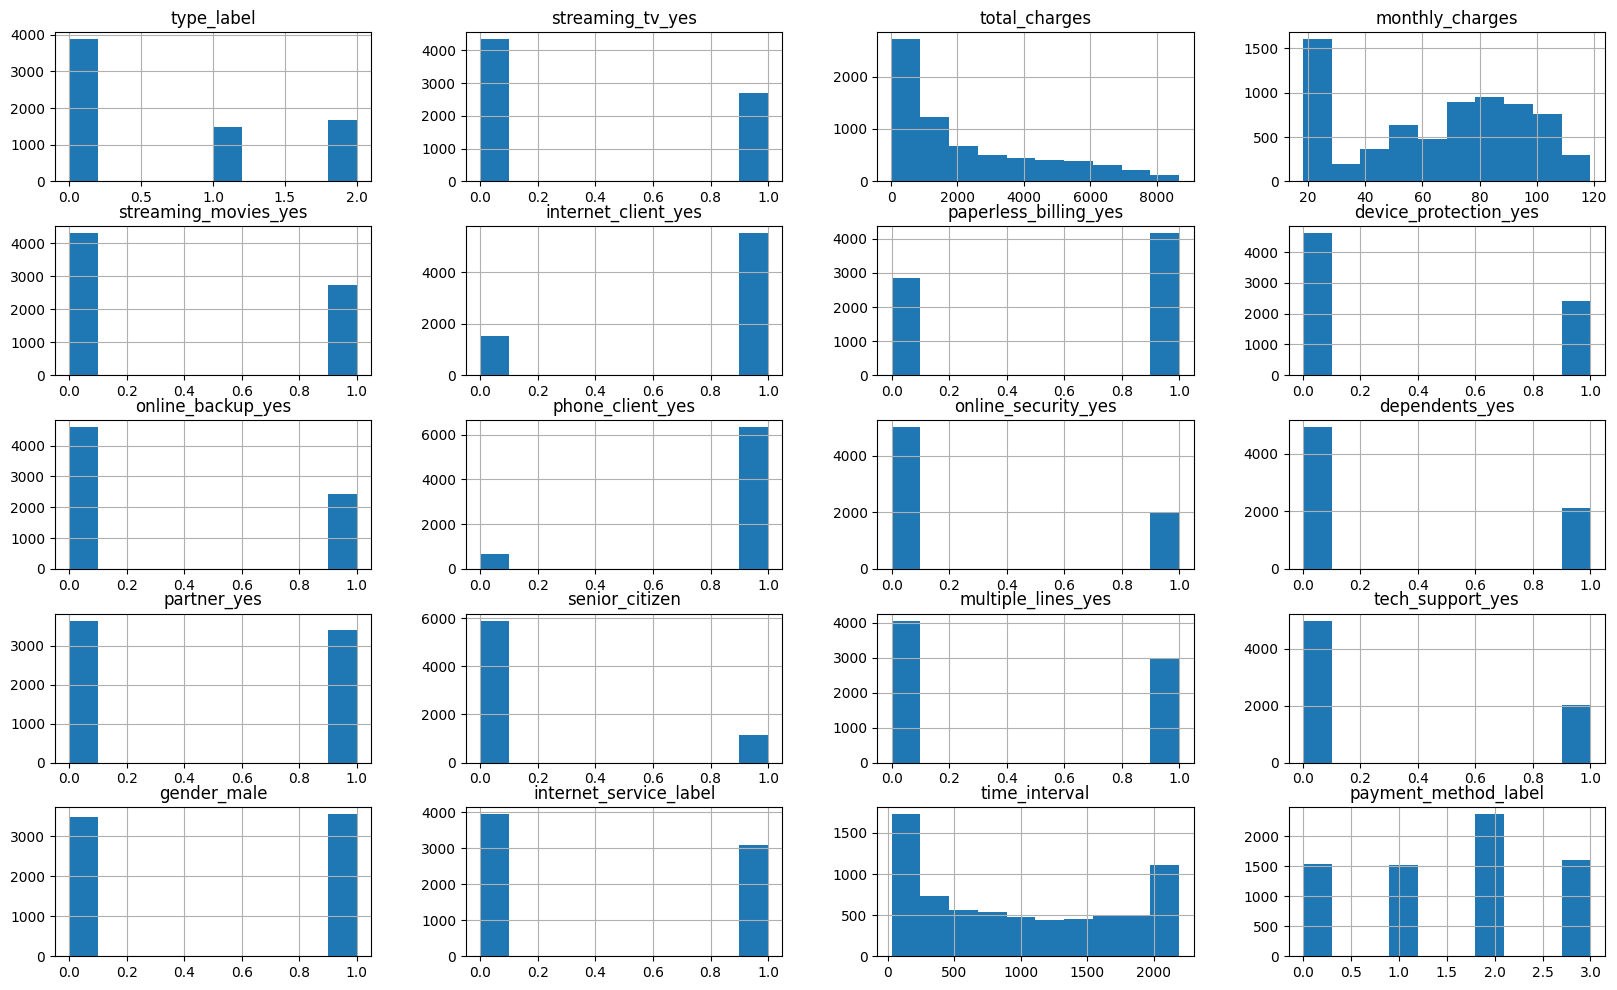

In [33]:
features_correlation = list(set(all_services.columns) - set(['customer_id','begin_date','end_date','type','payment_method','internet_service','client_left']))
all_services[features_correlation].hist(figsize=(20,12))

In [38]:
# функция вывода доли
def part_group(column, describe):
    k = all_services[all_services[column] == 1]['customer_id'].count() / all_services.shape[0]
    print(f'Доля \033[4m\033[1m\033[31m{describe}\033[0m составляет \033[4m\033[1m\033[31m{k:.2%}\033[0m от общего количества клиентов')

In [39]:
all_services.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'type_label',
       'payment_method', 'payment_method_label', 'monthly_charges',
       'total_charges', 'client_left', 'time_interval',
       'paperless_billing_yes', 'senior_citizen', 'gender_male', 'partner_yes',
       'dependents_yes', 'internet_service', 'internet_service_label',
       'online_security_yes', 'online_backup_yes', 'device_protection_yes',
       'tech_support_yes', 'streaming_tv_yes', 'streaming_movies_yes',
       'internet_client_yes', 'multiple_lines_yes', 'phone_client_yes'],
      dtype='object')

In [40]:
part_group('paperless_billing_yes', 'безналичного расчета')
part_group('senior_citizen', 'пенсионеров')
part_group('device_protection_yes', 'клиентов с доп. услугой «Антивирус»')
part_group('streaming_tv_yes', 'клиентов с доп. услугой «Стриминговое телевидение»')
part_group('online_backup_yes', 'клиентов с доп. услугой «Облачное хранилище файлов для резервного копирования данных»')
part_group('tech_support_yes', 'клиентов с доп. услугой «Выделенная линия технической поддержки»')
part_group('online_security_yes', 'клиентов с доп. услугой «Блокировка небезопасных сайтов»')
part_group('streaming_movies_yes', 'клиентов с доп. услугой «Каталог фильмов»')

Доля безналичного расчета составляет 59.27% от общего количества клиентов
Доля пенсионеров составляет 16.24% от общего количества клиентов
Доля клиентов с доп. услугой «Антивирус» составляет 34.39% от общего количества клиентов
Доля клиентов с доп. услугой «Стриминговое телевидение» составляет 38.44% от общего количества клиентов
Доля клиентов с доп. услугой «Облачное хранилище файлов для резервного копирования данных» составляет 34.49% от общего количества клиентов
Доля клиентов с доп. услугой «Выделенная линия технической поддержки» составляет 29.01% от общего количества клиентов
Доля клиентов с доп. услугой «Блокировка небезопасных сайтов» составляет 28.65% от общего количества клиентов
Доля клиентов с доп. услугой «Каталог фильмов» составляет 38.84% от общего количества клиентов


Видим, что среди бинарных признаков имеет место небольшой дисбаланс, 
- кроме сильного разброса в `клиент интернета` и `клиент телефонии`, максимумах в 5+ тысяч и 6+ тысяч - что с точки зрения бизнеса говорит нам о том, что многие клиенты все же пересекаются, используя и интернет и телефонную связь. 
- также видим, что основной массе клиентов характерно:
    - преобладает не пенсионный возраст (доля пенсионеров составляет всего 16,2%);
    - безналичный расчет (59%)
    - доп. услугами пользуется меньше половины всех клиентов (меньше ~35%), однако стоит отметить интерес людей к медиатеке - стриминговому сервису и фильмам
    - немного чаще люди пользуются Mailed check способом оплаты - оплата электронной квитанции через электронную почту?
    - подпочитают ежемесячную оплату услуг. 

Для количественных признаков: ежемесячные суммы, общие траты и период клиентства:
- заметен пик в принулевой зоне, т.е. это те клиенты:
    - которых не устроили те или иные условия, предлагаемые компанией, поэтому они расторгнули контракт
    - относительно недавно присоединившиеся, по которым информация не успела собраться в нужном объеме по времени
    - предпочитают тратить немного либо используют лишь малую часть предоставляемых услуг.

Для клиентства наблюдается нехарактерный спад после 3 лет пользования и снова повышение интереса.

На текущий момент можно сказать, что уход клиентов будет в большей степени связан с сферой интернет услуг, поэтому в этом направлении необходим будет сделать дополнительный анализ

Посмотрим также на общую статистику клиентов нашей компании

In [41]:
TT = all_services.pivot_table(index='client_left', columns=['internet_client_yes','phone_client_yes'], values='customer_id', aggfunc='count').reset_index(inplace=False)
TT.columns = ['client_left', 'only_phone', 'only_internet', 'phone_internet']
TT

,client_left,only_phone,only_internet,phone_internet
0,0,1407,510,3246
1,1,113,170,1586


[Text(0.5, 0, 'Факт ухода'), Text(0, 0.5, 'Количество клиентов')]

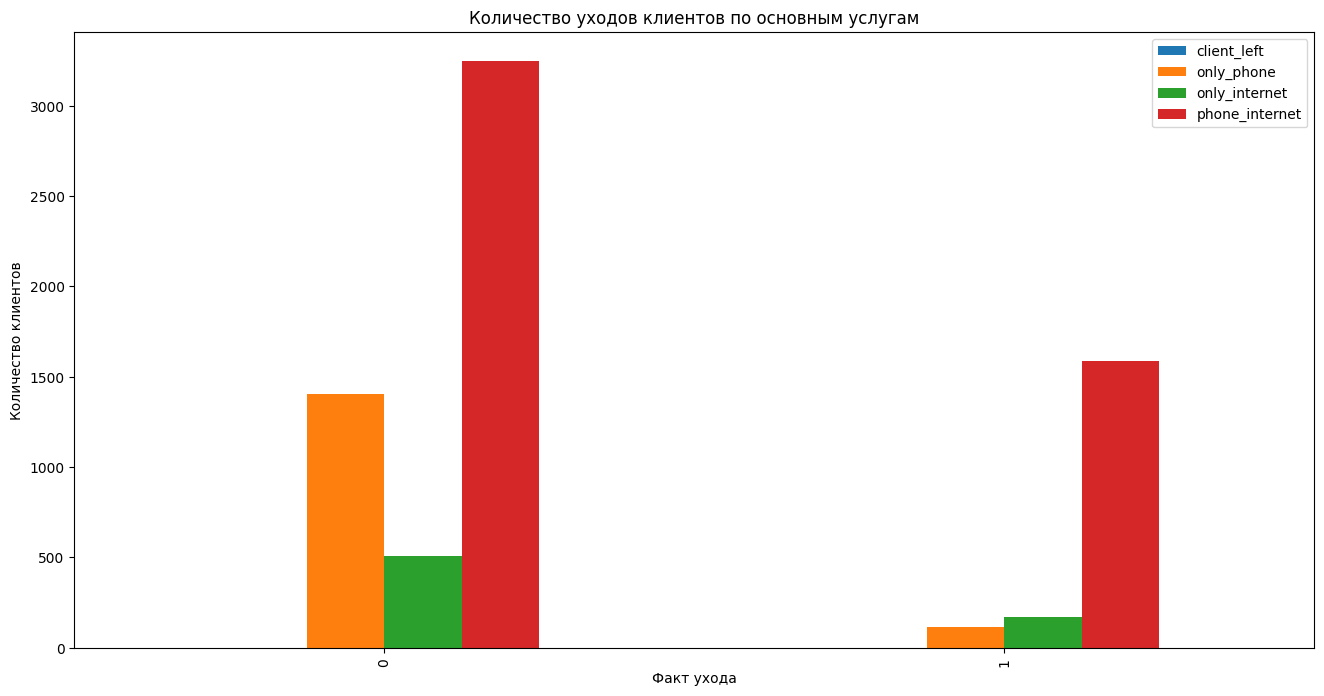

In [42]:
TT.plot(
    kind='bar',
    title='Количество уходов клиентов по основным услугам',
    legend=True,
    figsize=(16, 8)
).set(
    xlabel='Факт ухода',
    ylabel='Количество клиентов')

Треть клиентов ушла именно из сектора пользования и интернетом, и телефонией

---

### 2. Анализ корреляций категориальных признаков

Выделим категориальные признаки в отдельную переменную

In [43]:
cat_features = ['type_label','payment_method_label', 'paperless_billing_yes', 
                'senior_citizen', 'gender_male', 'partner_yes', 'dependents_yes', 
                'internet_service_label', 'online_security_yes', 'online_backup_yes', 
                'device_protection_yes', 'tech_support_yes', 'streaming_tv_yes', 
                'streaming_movies_yes', 'internet_client_yes', 'multiple_lines_yes', 
                'phone_client_yes']

Изучим корреляцию бинарных признаков с помощью фи коэффициента

In [44]:
phik_overview = all_services[cat_features + ['client_left']].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['type_label', 'payment_method_label', 'paperless_billing_yes', 'senior_citizen', 'gender_male', 'partner_yes', 'dependents_yes', 'internet_service_label', 'online_security_yes', 'online_backup_yes', 'device_protection_yes', 'tech_support_yes', 'streaming_tv_yes', 'streaming_movies_yes', 'internet_client_yes', 'multiple_lines_yes', 'phone_client_yes', 'client_left']


,type_label,payment_method_label,paperless_billing_yes,senior_citizen,gender_male,partner_yes,dependents_yes,internet_service_label,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,internet_client_yes,multiple_lines_yes,phone_client_yes,client_left
type_label,1.00,0.28,0.11,0.09,0.00,0.18,0.15,0.15,0.15,0.10,0.14,0.18,0.07,0.07,0.15,0.07,0.00,0.25
payment_method_label,0.28,1.00,0.37,0.29,0.00,0.24,0.22,0.56,0.26,0.28,0.31,0.27,0.38,0.38,0.53,0.34,0.00,0.45
paperless_billing_yes,0.11,0.37,1.00,0.24,0.00,0.01,0.17,0.49,0.00,0.20,0.16,0.06,0.34,0.33,0.48,0.25,0.02,0.30
senior_citizen,0.09,0.29,0.24,1.00,0.00,0.02,0.32,0.39,0.06,0.10,0.09,0.09,0.16,0.19,0.28,0.22,0.00,0.23
gender_male,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
partner_yes,0.18,0.24,0.01,0.02,0.00,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.00,0.22,0.02,0.23
dependents_yes,0.15,0.22,0.17,0.32,0.00,0.65,1.00,0.25,0.12,0.03,0.01,0.10,0.02,0.06,0.21,0.03,0.00,0.25
internet_service_label,0.15,0.56,0.49,0.39,0.00,0.00,0.25,1.00,0.04,0.26,0.27,0.03,0.49,0.48,0.67,0.54,0.44,0.46
online_security_yes,0.15,0.26,0.00,0.06,0.02,0.22,0.12,0.04,1.00,0.43,0.42,0.53,0.27,0.29,0.50,0.15,0.14,0.26
online_backup_yes,0.10,0.28,0.20,0.10,0.01,0.22,0.03,0.26,0.43,1.00,0.46,0.44,0.43,0.42,0.56,0.31,0.08,0.13


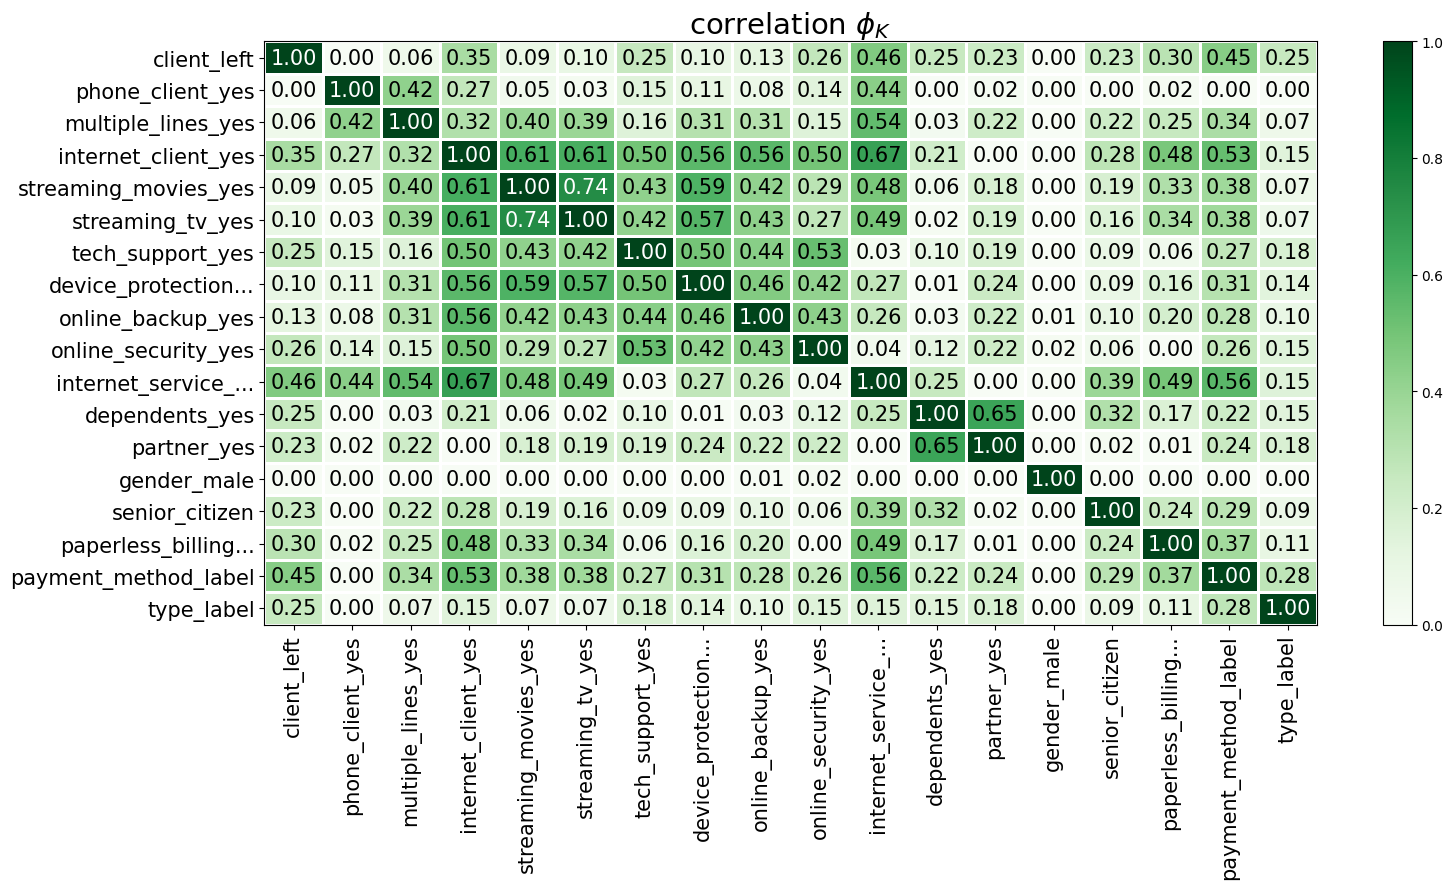

In [45]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 9))
plt.tight_layout()

Сразу бросается в глаза:
- прям криминального влияния на уход клиента нет среди признаков, хотя есть те, что этому способствуют: способ подключения интернета `internet_service_label`, `безналичный расчет`, `способ оплаты`, `является ли интернет клиентом`, в равной степени `возраст клиента`, `семейное положение`, `наличие детей` и `блокировка сайтов`;
- мультиколлинеарности признаков между собой не наблюдаю, кроме разве что стриммингового телевидения и доступу к каталогу фильмов - возможно эти две услуги чаще всего идут в одном пакете.

Для категориальных признаков также изучим взаимосвязь на основании таблиц сопряжённости (кросс-таблиц).

In [46]:
def corr_cat(cat_feature, target):
    print('\n', 'Отношение признака \033[4m\033[1m\033[31m{}\033[0m к целевому признаку \033[4m\033[1m\033[31m{}\033[0m:'.format(cat_feature, 'target'))
    print('\n \033[4m\033[1m\033[31m{}\033[0m'.format('Кросс-таблица:'))
    display(pd.crosstab(all_services[cat_feature], all_services[target]))
    sb.heatmap(pd.crosstab(all_services[cat_feature], all_services[target]), 
            cmap="YlGnBu", annot=True, cbar=False)
    plt.title('Тепловая карта количественных отношений')
    plt.show()
    
    result_pvalue = chi2_contingency(pd.crosstab(all_services[cat_feature], all_services[target]))[1]
    print('Значение p-value равно:', result_pvalue)
    if (result_pvalue < alpha):
        print('Cвязь статистически \033[4m\033[1m\033[31m{}\033[0m'.format('подтверждается'))
    else:
        print('Cвязь статистически \033[4m\033[1m\033[31m{}\033[0m'.format('не подтверждается'))
    print('\n' , '--' * 40)


 Отношение признака type_label к целевому признаку target:

 Кросс-таблица:


client_left,0,1
type_label,,
0,2220,1655
1,1306,166
2,1637,48


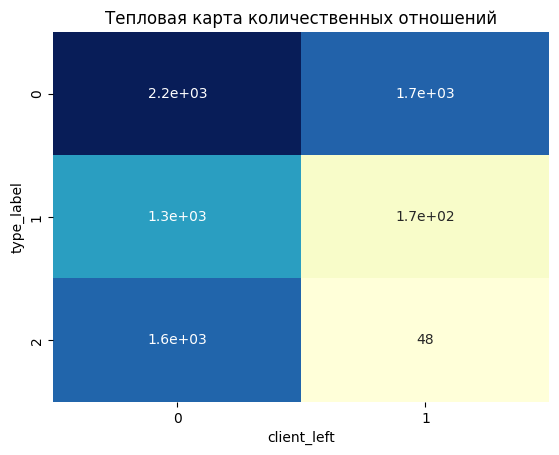

Значение p-value равно: 7.326182186265472e-257
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака payment_method_label к целевому признаку target:

 Кросс-таблица:


client_left,0,1
payment_method_label,,
0,1284,258
1,1289,232
2,1294,1071
3,1296,308


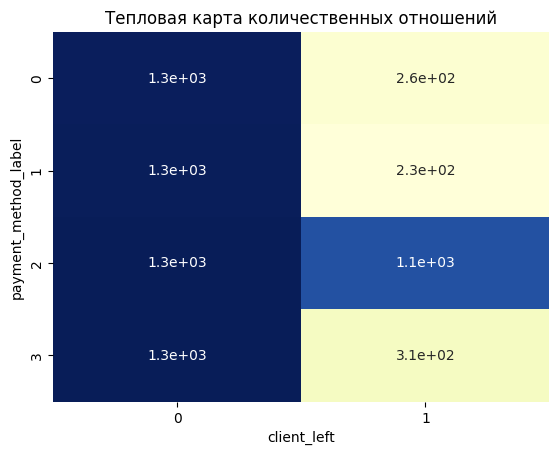

Значение p-value равно: 1.4263098511063342e-139
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака paperless_billing_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
paperless_billing_yes,,
0,2395,469
1,2768,1400


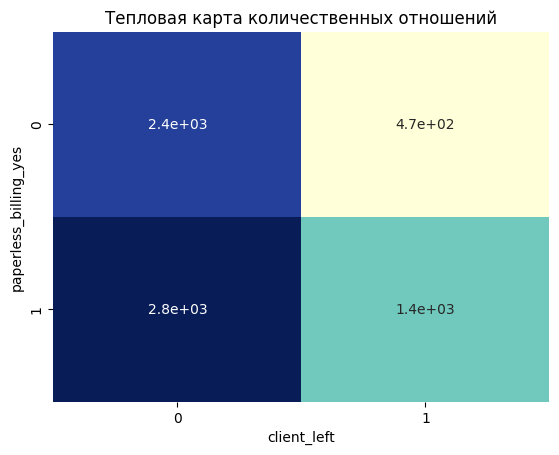

Значение p-value равно: 8.236203353962564e-58
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака senior_citizen к целевому признаку target:

 Кросс-таблица:


client_left,0,1
senior_citizen,,
0,4497,1393
1,666,476


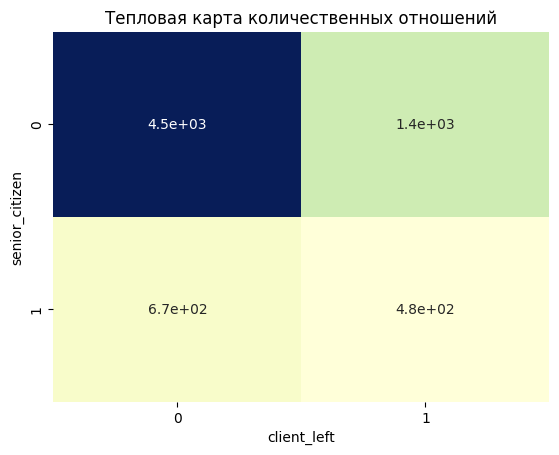

Значение p-value равно: 2.4792557203954705e-36
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака gender_male к целевому признаку target:

 Кросс-таблица:


client_left,0,1
gender_male,,
0,2544,939
1,2619,930


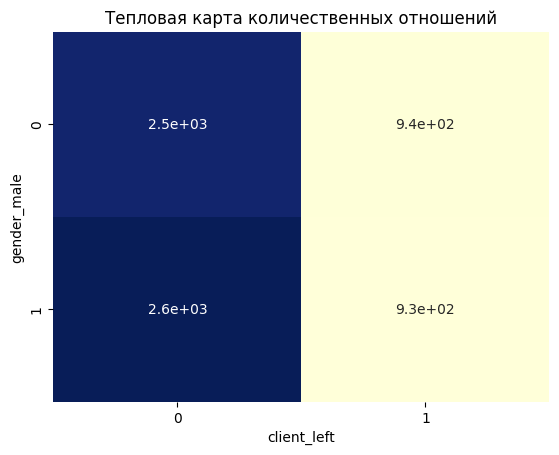

Значение p-value равно: 0.4904884707065509
Cвязь статистически не подтверждается

 --------------------------------------------------------------------------------

 Отношение признака partner_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
partner_yes,,
0,2439,1200
1,2724,669


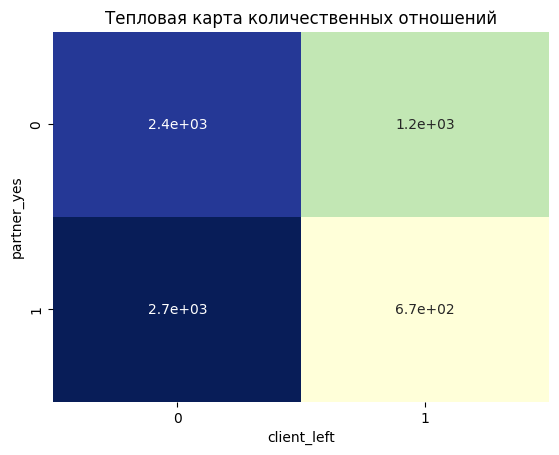

Значение p-value равно: 3.97379757451591e-36
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака dependents_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
dependents_yes,,
0,3390,1543
1,1773,326


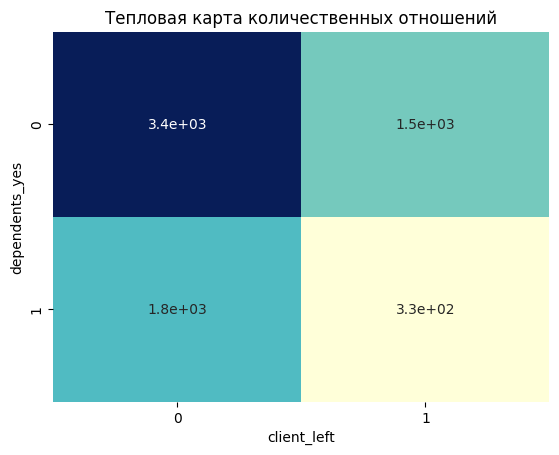

Значение p-value равно: 2.0196592017051303e-42
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака internet_service_label к целевому признаку target:

 Кросс-таблица:


client_left,0,1
internet_service_label,,
0,3364,572
1,1799,1297


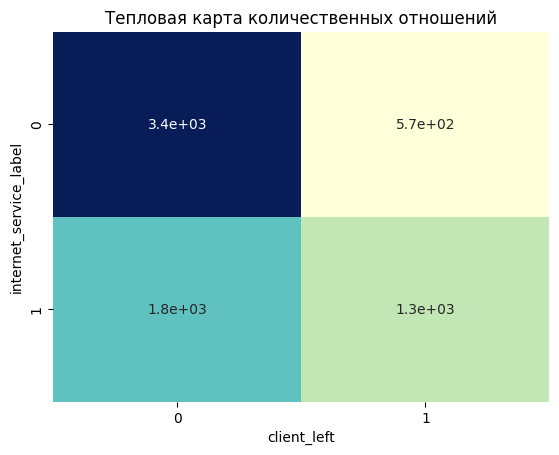

Значение p-value равно: 2.782210278669653e-146
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака online_security_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
online_security_yes,,
0,3443,1574
1,1720,295


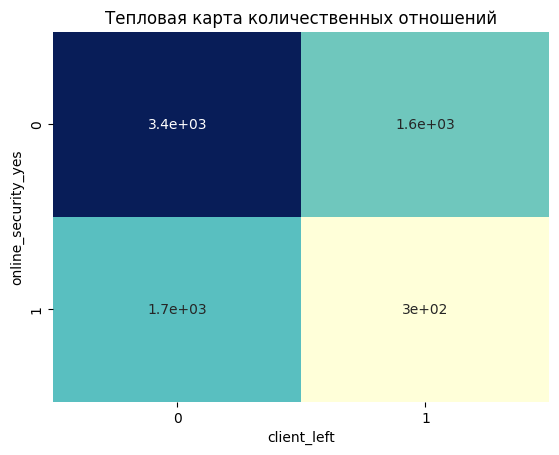

Значение p-value равно: 1.37424000884718e-46
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака online_backup_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
online_backup_yes,,
0,3261,1346
1,1902,523


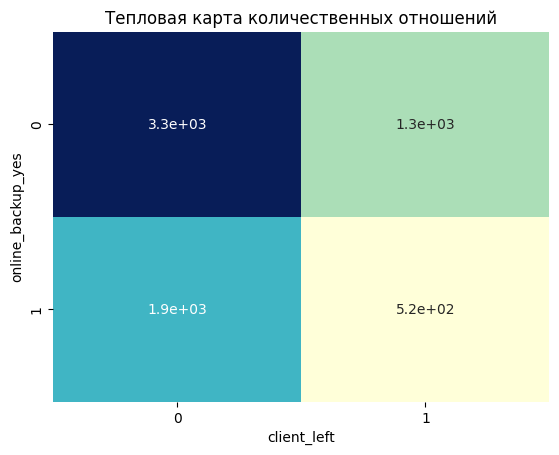

Значение p-value равно: 6.259257129714726e-12
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака device_protection_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
device_protection_yes,,
0,3290,1324
1,1873,545


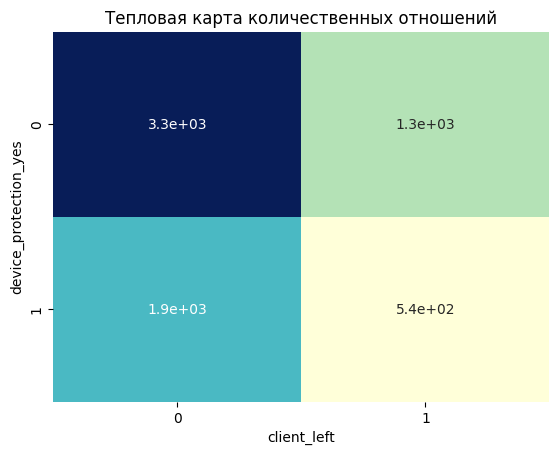

Значение p-value равно: 3.346074945648779e-08
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака tech_support_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
tech_support_yes,,
0,3433,1559
1,1730,310


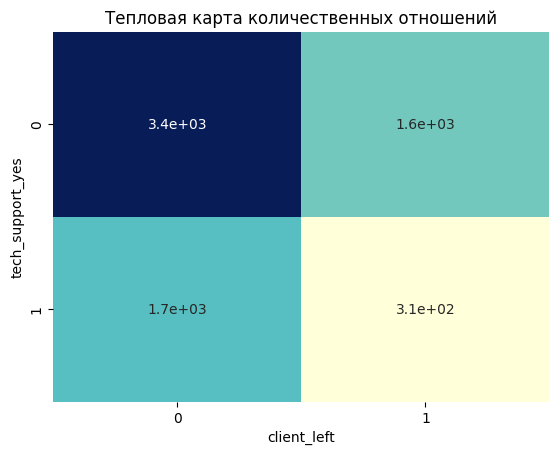

Значение p-value равно: 3.2328683255491206e-43
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака streaming_tv_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
streaming_tv_yes,,
0,3274,1055
1,1889,814


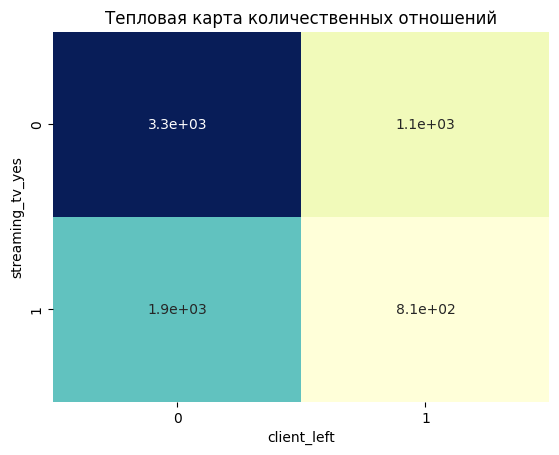

Значение p-value равно: 1.3164336109407092e-07
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака streaming_movies_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
streaming_movies_yes,,
0,3250,1051
1,1913,818


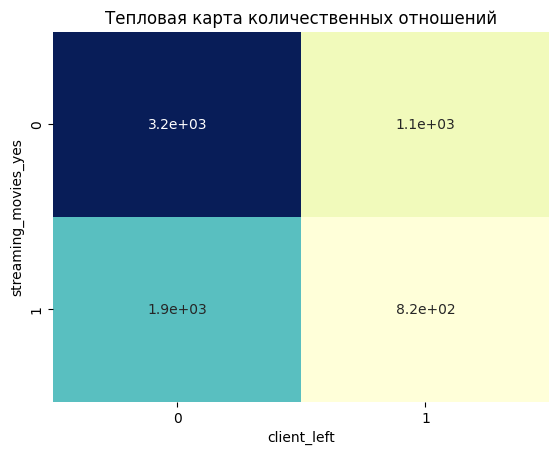

Значение p-value равно: 3.857900347663822e-07
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака internet_client_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
internet_client_yes,,
0,1407,113
1,3756,1756


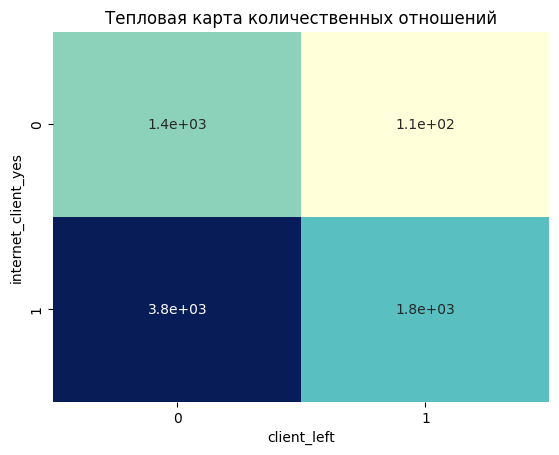

Значение p-value равно: 6.4225207979072035e-81
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака multiple_lines_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
multiple_lines_yes,,
0,3046,1019
1,2117,850


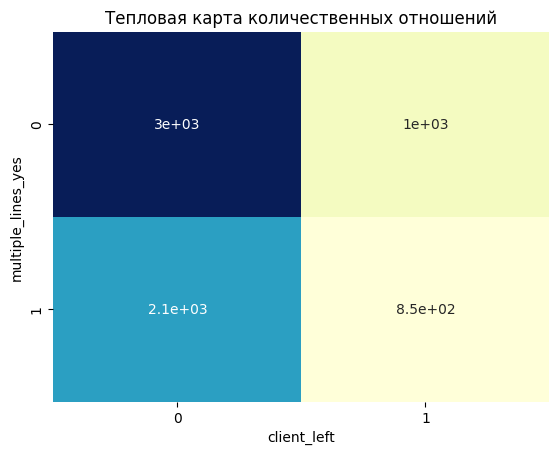

Значение p-value равно: 0.0008694082815826175
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------

 Отношение признака phone_client_yes к целевому признаку target:

 Кросс-таблица:


client_left,0,1
phone_client_yes,,
0,510,170
1,4653,1699


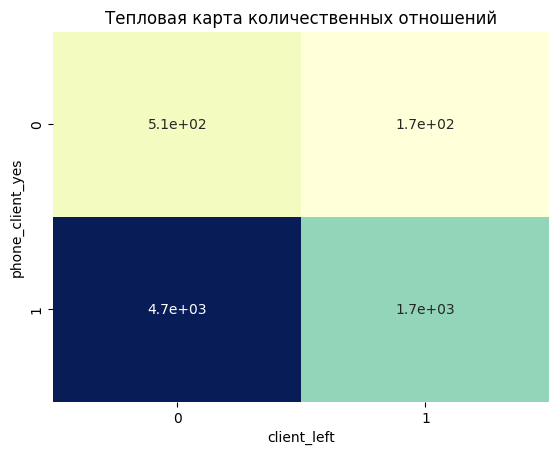

Значение p-value равно: 0.34992398942431924
Cвязь статистически не подтверждается

 --------------------------------------------------------------------------------


In [47]:
alpha = 0.05

for cat_feature in cat_features:
    corr_cat(cat_feature, 'client_left')

Добавим еще один признак и проверим его связь с целевым. Так как информация использует ли клиент основные услуги телефонной связи не влияет на факт ухода, но при этом обнаружена зависимость, что больше всего ушедших клиентов пользовались и телефонией, и интернетом нашей компании, то и создадим именно такой признак, где:
- `0` - only_phone, 
- `1` - only_internet, 
- `2` - phone_internet

In [48]:
def main_traffic(row):
    internet = row['internet_client_yes']
    phone = row['phone_client_yes']

    if internet == 1 and  phone == 1:
        return 2
    if internet == 1 and  phone == 0:
        return 1
    return 0

In [49]:
all_services['type_of_main_traffic'] = all_services.apply(main_traffic, axis=1)

Проверим

In [50]:
all_services[['internet_client_yes', 'phone_client_yes', 'type_of_main_traffic']].head(5)

,internet_client_yes,phone_client_yes,type_of_main_traffic
0,1,0,1
1,1,1,2
2,1,1,2
3,1,0,1
4,1,1,2



 Отношение признака type_of_main_traffic к целевому признаку target:

 Кросс-таблица:


client_left,0,1
type_of_main_traffic,,
0,1407,113
1,510,170
2,3246,1586


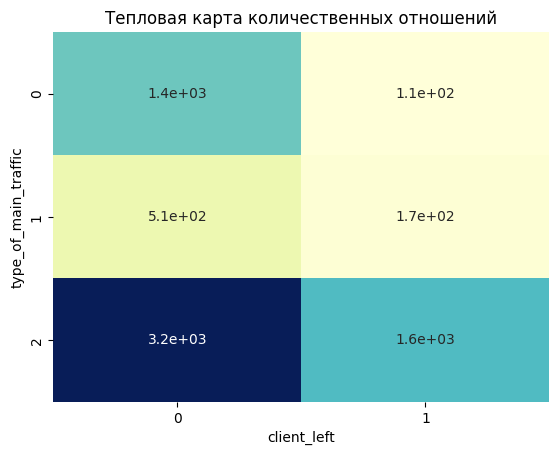

Значение p-value равно: 7.177610870660059e-84
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------


In [51]:
corr_cat('type_of_main_traffic', 'client_left')

Отлично, таким образом мы сохранили важную информацию об основных услугах и разделении клиентов, а также удастся избавиться от лишних признаков.

И еще один признак: месяц подписания контракта. Эта информация важна из вышеописанных случаев, когда люди становятся клиентами компании, заманияваясь интересными временными предложениями. Однако так как это временной признак, то наши модели могут попасть в ловушку, неправильно интрерпретировав взаимосвязь между фактом ухода клиента, месяцем подписания контракта и длительностью клиентства. Поэтому мы лишь посмотрим на наличие интересных закономерностей и попытаемся сделать выводы.

In [52]:
all_services['begin_month'] = all_services['begin_date'].dt.month


 Отношение признака begin_month к целевому признаку target:

 Кросс-таблица:


client_left,0,1
begin_month,,
1,529,94
2,671,122
3,483,107
4,413,98
5,368,126
6,390,132
7,376,142
8,381,151
9,366,257


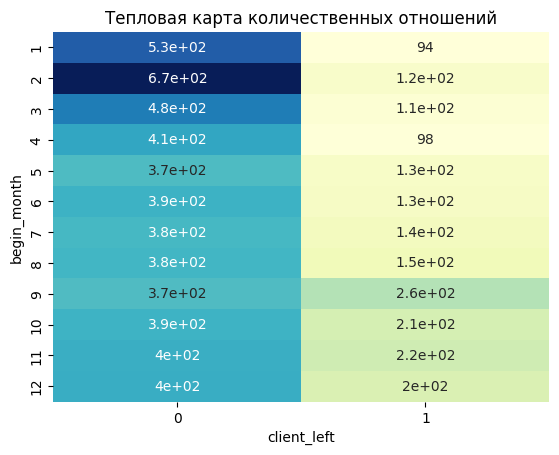

Значение p-value равно: 5.9806861893182e-51
Cвязь статистически подтверждается

 --------------------------------------------------------------------------------


In [53]:
corr_cat('begin_month', 'client_left')

Как мы видим, отток клиентов к концу года уменьшается после осеннего пика. Получается, что это люди, пришедшие в компанию ближе к концу года с большой долей вероятности вскоре ее покинут. Возможно дело в агрессивной маркетинговой компании, предлагающей выгодные условия новым клиентам, но только на время.

Таким образом, можно утверждать, что из имеющихся признаков не имеют непосредственной связи с уходом клиентов такие категориальные признаки, как: 
- использует ли клиент основные услуги телефонной связи
- гендерное разделение

Среди же взаимосвязанных наблюдаются следующие тенденции:
- клиенты с помесячным способом оплаты чаще уходят (почти `88%` от всех клиентов с таким способом оплаты услуг) нежели те, кто платит сразу на год или даже на два. Этот способ оплаты выбирает большинство клиентов `55%`, однако наиболее преданными являются те, кто оформляет подписку на 2 года.
- среди ушедших большой процент людей (`57%`) , кто оплачивал услуги через электронные чеки, это же и самым популярный выбор `33,6%`, остальные способы в равной степени удерживают клиентов, но автоматическая оплата чуть-чуть лучше.
- `74,9%` уходящих оплачивали услуги безналичным расчетом, при этом остается самым популярным среди пользователей услуг `59%`
- `41,7%` пожилых людей разрывают контракты, хотя они составляют лишь 19% от всей клиентской базы
- почти `64%` одиноких людей и `82,6%` бездетных со временем отказываются от дальнейшего сотрудничества. Интересно, что многие клиенты не имеют детей в своих семьях, а это значит, что данная ниша открыта.
- `69,4%` среди растогнувших пользовались новой технологией подключения интернета Fiber optic. Возможно, есть проблемы с поставляемым оптоволоконным кабелем или частыми повреждениями на магистральном канале, на момент выгрузки БД процент перехода на современные технологии среди текущих пользователей составил всего `34,8%`
- `93,95%` процент растогнувших контракт людей пользовались интернетом, при этом клиентов интернета у данной компании немногим меньше, чем телефонией - вот оно **слабое место** компании, которое необходимо грейдить
- однозначно можно сказать, что наличие таких дополительных услуг в сервисном пакете, как: 
    - здесь и далее указан процент ушедших клиентов по отношению к оставшимся с активным пакетом против тех, у кого данная услуга не была активна: 
        - блокировка небезопасных сайтов вкл. `14,6%` - выкл. `31,4%` ; вот она сила удержания тех, у кого проплачена блокировка :) 
        - облачное хранилище вкл. `21,6%` - выкл. `29,2%` ; не большая разница...
        - антивирус вкл. `22,5%` - выкл. `28,7%` ; не большая разница...
        - тех. поддержка вкл. `15%` - выкл. `31%` ; индивидуальная работа с клиентами показвает отличные результаты по удержанию
        - стриминговое телевидение вкл. `30%` - выкл. `24%` ; по всей видимости данный сервис нуждается в доработке, так как 30% людей услуга не удерживает. Стоит маркетологам обратить на это внимание и провести исследование по сбору фидбека
        - доступ к каталогу фильмов вкл. `30%` - выкл. `24%` ; по всей видимости данный сервис нуждается в доработке, так как 30% людей услуга не удерживает. Стоит маркетологам обратить на это внимание и провести исследование по сбору фидбека
        - возможность подключения телефонного аппарата к нескольким линиям одновременно вкл. `28,6%` - выкл. `25%` ; разница небольшая, однако небольшой негатив имеется, нужно провести опрос и работу с клиентами, кто пользуется данной функцией
        
    - здесь и далее указан процент ушедших клиентов с активным пакетом по отношению к тем, кто не пользовался доп. услугой:
        - блокировка небезопасных сайтов вкл. `15,7%` ; только 15% расторгнувших контракт использовали данный сервис. Может следовало предложить попробовать?
        - облачное хранилище вкл. `27,98%` ; стоит попробовать предлагать данный вид доп. услуг
        - антивирус вкл. `29%` ; стоит попробовать предлагать данный вид доп. услуг
        - тех. поддержка вкл. `16,6%` ; определенно стоит уделить данной фиче отдельное внимание
        - стриминговое телевидение вкл. `43,5%` ; еще одно подтверждение вышеописанному предположению
        - доступ к каталогу фильмов вкл. `43,8%` ; еще одно подтверждение вышеописанному предположению
        - возможность подключения телефонного аппарата к нескольким линиям одновременно вкл. `45,5%` ; вероятно это не тот фактор, который может повлиять на решение людей уйти        
        
    - здесь и далее указан процент оставшихся клиентов с активным пакетом:
        - блокировка небезопасных сайтов вкл. `33,3%`
        - облачное хранилище вкл. `36,8%`
        - антивирус вкл. `36,3%`
        - тех. поддержка вкл. `33,5%`
        - стриминговое телевидение вкл. `36,6%` ; интерес у пользователей определенно есть, а вот удовлетворенность посредственная
        - доступ к каталогу фильмов вкл. `37%` ; интерес у пользователей определенно есть, а вот удовлетворенность посредственная
        - возможность подключения телефонного аппарата к нескольким линиям одновременно вкл. `41%` ; большой процент пользующихся

### 3. Анализ корреляций количественных признаков

In [54]:
features_correlation_num = list(set(all_services.columns) - 
                                set(['customer_id','begin_date',
                                     'end_date','type','payment_method',
                                     'internet_service','client_left', 
                                     'type_of_main_traffic']) - 
                                set(cat_features) - 
                                set(['type_of_main_traffic']))

Построим матрицу диаграмм, где на главной диагонали видим распределения признаков, а вне главной диагонали – диаграммы рассеяния для пар признаков (целевым признаком укажем факт ухода клиента)

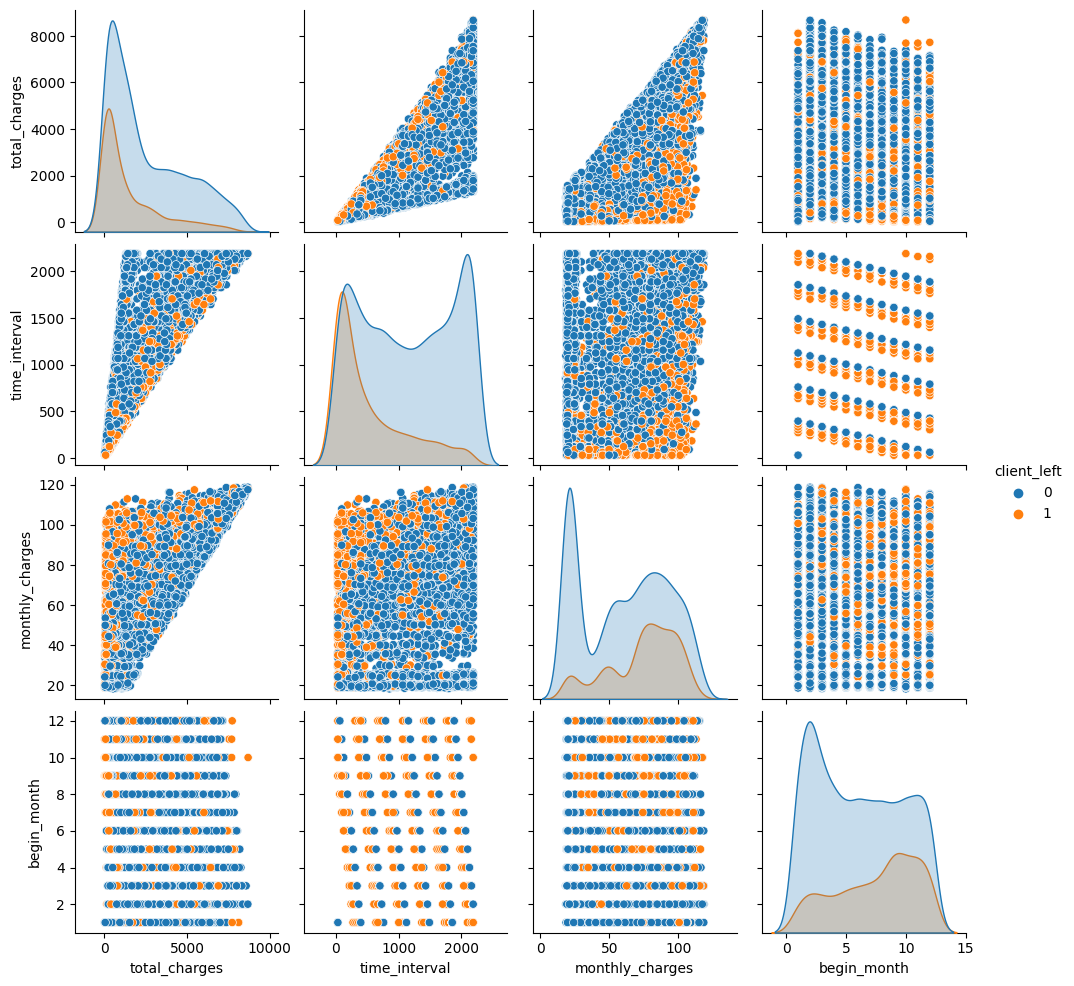

In [55]:
sb.pairplot(all_services[features_correlation_num + ['client_left']], hue='client_left')

Выведем также корреляцию в виде таблицы для количественных признаков

In [56]:
(all_services[features_correlation_num + ['client_left']]).corr()

,total_charges,time_interval,monthly_charges,begin_month,client_left
total_charges,1.000000,0.825811,0.651065,-0.196624,-0.199484
time_interval,0.825811,1.000000,0.246715,-0.233464,-0.354496
monthly_charges,0.651065,0.246715,1.000000,-0.019613,0.192858
begin_month,-0.196624,-0.233464,-0.019613,1.000000,0.180522
client_left,-0.199484,-0.354496,0.192858,0.180522,1.000000


Наблюдается нездоровая зависимость общих трат и времени, хотя оно и понятно - чем дольше клиент пользуется услугами, тем больше он платит по общему итогу. Скорее всего при выборе признаков будем использовать именно временной признак.

В случае бинарного категориального признака и числового признака мы также можем применить бисериальный коэффициент корреляции

In [57]:
for num_feature in features_correlation_num:
    print('\nПризнак \033[4m\033[1m\033[31m{}\033[0m:'.format(num_feature))
    print(pointbiserialr(all_services[num_feature], all_services['client_left']))
    
    result_pvalue_num = pointbiserialr(all_services[num_feature], all_services['client_left'])[1]
    if (result_pvalue_num < alpha):
        print('Cвязь статистически \033[4m\033[1m\033[31m{}\033[0m'.format('подтверждается'))
    else:
        print('Cвязь статистически \033[4m\033[1m\033[31m{}\033[0m'.format('не подтверждается'))
    print('--' * 40)


Признак total_charges:
PointbiserialrResult(correlation=-0.1994840835675714, pvalue=4.8768656897028774e-64)
Cвязь статистически подтверждается
--------------------------------------------------------------------------------

Признак time_interval:
PointbiserialrResult(correlation=-0.35449591742477626, pvalue=2.642320808035117e-207)
Cвязь статистически подтверждается
--------------------------------------------------------------------------------

Признак monthly_charges:
PointbiserialrResult(correlation=0.19285821847008577, pvalue=6.760843117991897e-60)
Cвязь статистически подтверждается
--------------------------------------------------------------------------------

Признак begin_month:
PointbiserialrResult(correlation=0.18052204685562, pvalue=1.3934439203977373e-52)
Cвязь статистически подтверждается
--------------------------------------------------------------------------------


### **Промежуточные выводы**

   Каждый объект в наборе данных — данные об уникальном клиенте, использующим те или иные услуги компании. Имеется несколько таблиц, часть из них описывает общие параметры клиента: возраст, семейная информация. Остальные данные рассказывают о бизнес отношениях: затрачиваемые суммы, сколько человек является клиентом, расторгался ли договор, какие основные и дополнительные услуги клиент использует (иными словами, его активность и вовлеченность в продукты компании).
    
   При начальном осмотре также выявлено, что не все пользуются сразу и интернетом, и телефонией, следовательно для компании это "потенциальные" клиента дополнительных услуг. Составлена первичная модель потребиля, которую необходимо будет раскрыть в дальнейшем анализе.
    
   Дубликатов или пропусков найдено не было.
   
   Найдены возможные аномалии в количественных признаках: ежемесячные суммы, общие траты и период клиентства, которые необходимо будет исследовать более детально.
   
   В нашем распоряжении очень много признаков, так что в дальнейшем потребуется выбрать только самые значительные с помощью feature_importances_, оказывающие влияние на обучаемые модели.

<a id='hitch'></a> 
### 4. Анализ выброса признака: *длительность клиентства*

Посмотрим поближе на распределение данного признака, заранее ограничив временной промежуток **500 днями**

(0.0, 500.0)

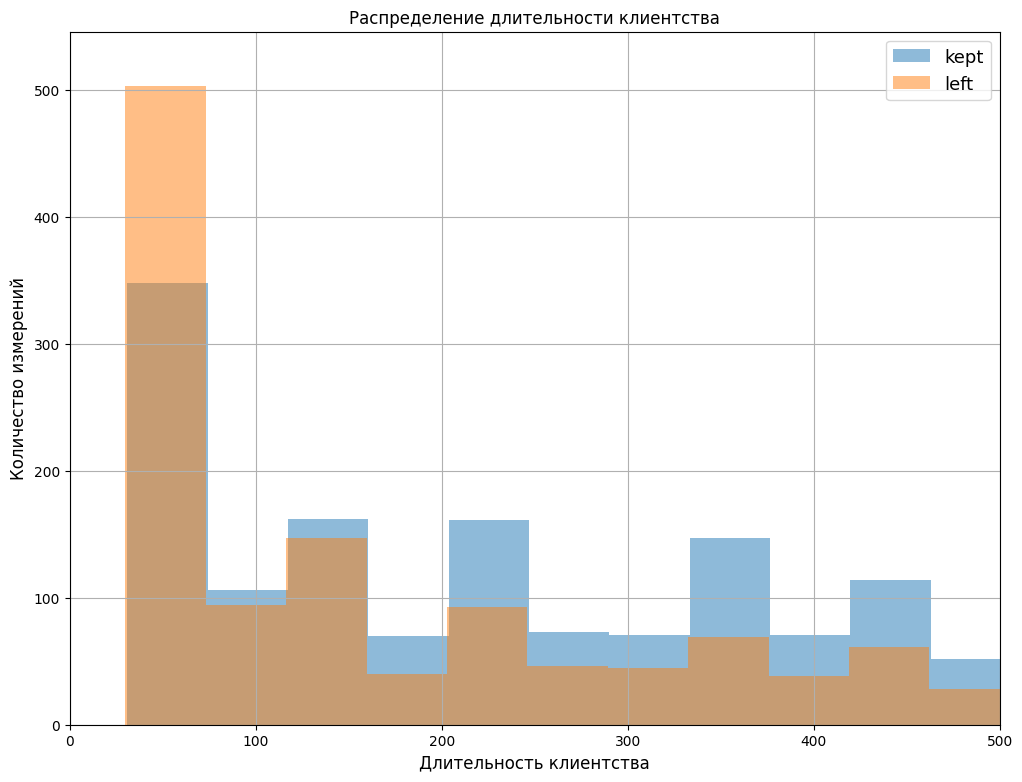

In [58]:
plt.figure(figsize=[12,9])

all_services.groupby('client_left')['time_interval'].hist(
    bins=50, 
    alpha=.5)

plt.xlabel('Длительность клиентства', fontsize = 12)
plt.ylabel('Количество измерений', fontsize = 12)

plt.legend(['kept', 'left'], loc='upper right', fontsize=13)
plt.title('Распределение длительности клиентства')
plt.xlim((0,500))

Видим, что много клиентов уходит после 70 дней. Взглянем на них поподробнее

In [59]:
# выведем их в отдельную переменную
less_70_d = all_services.query('client_left == 1 and time_interval < 70')

# наличие дополнительных услуг
add_service = ['online_security_yes', 'online_backup_yes', 
               'device_protection_yes', 'tech_support_yes', 'streaming_tv_yes', 
               'streaming_movies_yes', 'multiple_lines_yes']

# принадлежность основному сервису
main_service = ['type_of_main_traffic', 'internet_service_label']

# способы взаимосвязи с компанией
pay_info = ['type_label', 'payment_method_label', 'paperless_billing_yes']

# персональная информация
pers_info = ['senior_citizen', 'gender_male', 'partner_yes', 'dependents_yes']

date_info = ['begin_date', 'end_date']

In [60]:
print('Количество клиентов выброса 2019 года:', less_70_d.shape[0], 
      'что составляет \033[4m\033[1m\033[31m{} %\033[0m от общего числа пользователей в базе данных'
      .format(round(less_70_d.shape[0] / all_services.shape[0] * 100, 2))
     )

Количество клиентов выброса 2019 года: 503 что составляет 7.15 % от общего числа пользователей в базе данных


Функция для вывода гистограммы по интересующей информации. Выведем инфомацию по годам подписания договора и его расторжения

In [61]:
def hist_analisys(data, info, name, axeX_name):
    plt.figure(figsize=[10,6])
    for service in info:
        plt.hist(data[service], 
                 bins=4, 
                 label=service, 
                 alpha=.4)

    plt.xlabel(axeX_name, fontsize = 12)
    plt.ylabel('Количество измерений', fontsize = 12)
    plt.legend(loc='upper right', fontsize=13)
    plt.title(name, fontsize = 14)

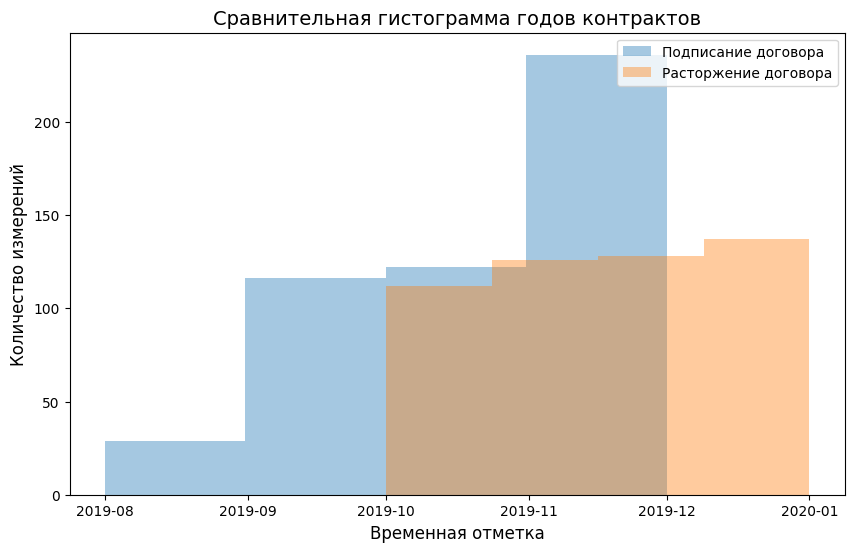

In [62]:
hist_analisys(less_70_d, date_info, 'Сравнительная гистограмма годов контрактов', 'Временная отметка')
plt.legend(['Подписание договора', 'Расторжение договора'], loc='upper right', fontsize=10)

А вот и наши клиенты, выбросом пришедшие осенью 2019 года и ушедшие к новому 2020 году. Видимо в этот период проходила агрессивная маркетинговая компания по привлечению новых клиентов, но на тот момент не способна была их удержать по тем или иным причинам.

Посмотрим, какими сервисами пользовались эти люди и кто это был

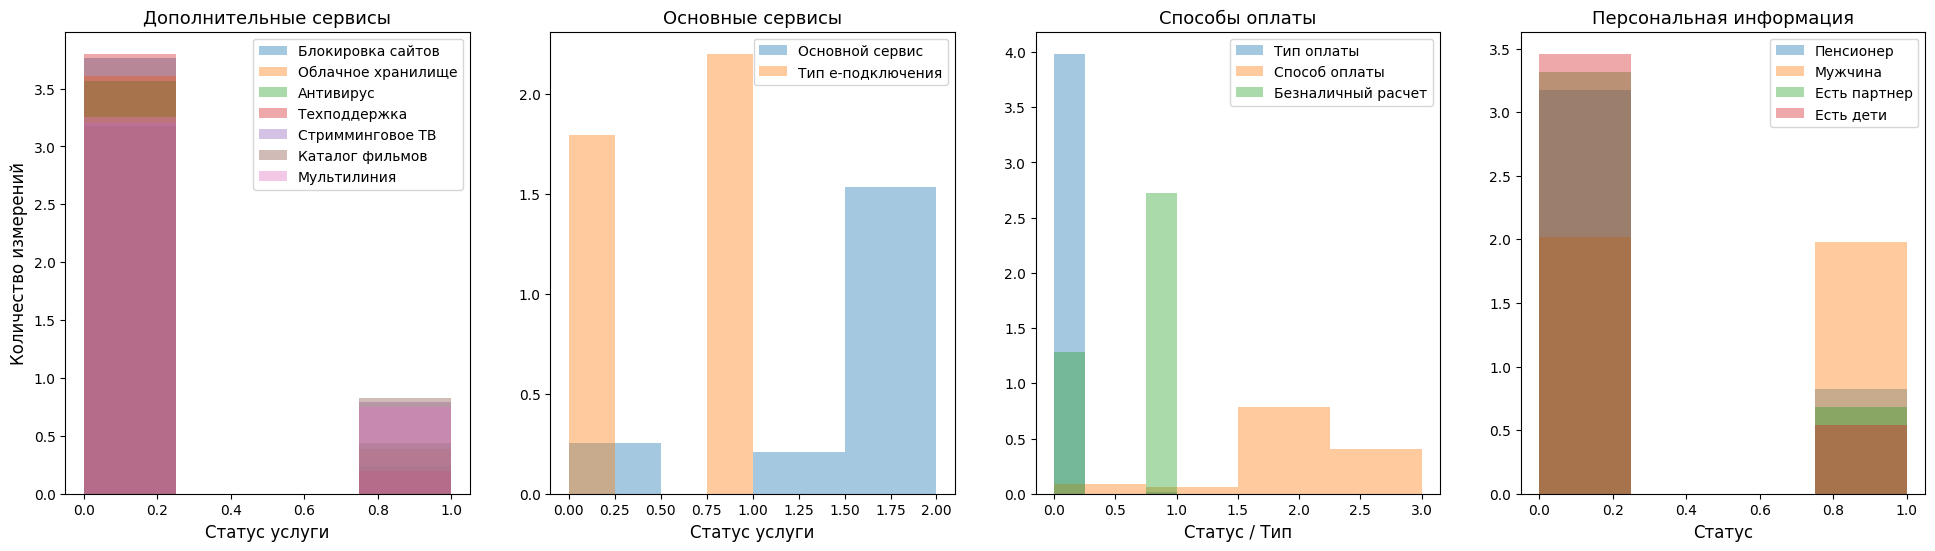

In [63]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4, figsize = (24, 6))
k = 0
x = [ax1, ax2, ax3, ax4]

for info in [add_service, main_service, pay_info, pers_info]:
    ax = x[k]
    for service in info:
        ax.hist(
            less_70_d[service], 
            bins=4, 
            density=True, 
            alpha=.4)
    k += 1

# наличие дополнительных услуг
ax1.set_title('Дополнительные сервисы', fontsize = 13)
ax1.set_xlabel('Статус услуги', fontsize = 12)
ax1.set_ylabel('Количество измерений', fontsize = 12)
ax1.legend(['Блокировка сайтов', 'Облачное хранилище', 'Антивирус', 
            'Техподдержка', 'Стримминговое ТВ', 'Каталог фильмов', 
            'Мультилиния'], loc='upper right', fontsize=10)

# принадлежность основному сервису
ax2.set_title('Основные сервисы', fontsize = 13)
ax2.set_xlabel('Статус услуги', fontsize = 12)
ax2.legend(['Основной сервис', 'Тип e-подключения'], 
           loc='upper right', fontsize=10)

# способы взаимосвязи с компанией
ax3.set_title('Способы оплаты', fontsize = 13)
ax3.set_xlabel('Статус / Тип', fontsize = 12)
ax3.legend(['Тип оплаты', 'Способ оплаты', 'Безналичный расчет'], 
           loc='upper right', fontsize=10)

# персональная информация
ax4.set_title('Персональная информация', fontsize = 13)
ax4.set_xlabel('Статус', fontsize = 12)
ax4.legend(['Пенсионер', 'Мужчина', 'Есть партнер', 'Есть дети'], 
           loc='upper right', fontsize=10)

### **Промежуточные выводы**

Найдена интересная закономерность для бизнеса:
- наблюдается скачок активности прихода в начале осени 2019 года и ухода к новому 2020 году. Видимо в этот период проходила агрессивная маркетинговая компания по привлечению новых клиентов, но на тот момент не способна была их удержать по тем или иным причинам.
- почти все ушедшие в этот период так и не попробовали дополнительные услуги
- все они пользовались интернет+телефон
- для статистики эти клиенты использовали и DLS, и оптический кабель
- это были одинокие люди не пенсионного возраста, как мужчины так и женщины, без детей. Есть подозрение, что они были относительно молодые, заинтересовавшиеся выгодным предложением-акцией. Контенгент людей, находящийся постоянно в поиске наиболее выгодного предложения низкая цена+высокое качество

<a id='split_data'></a>
## 5. Сплит данных на выборки 

### 5.1. Первичная чистка признаков

Удалим из данных, признаки не оказывающие никакого влияния на ответ на интересующий нас вопрос или дублирующие, а именно:
- уникальный номер клиента
- даты начала и окончания действия контракта
- **общие затраты по ранее установленной логике, что данный признак перекрывается месячной тратой**
- гендерное разделение
- дублирующие признаки: 
        - тип оплаты, 
        - способ оплаты, 
        - способ подключения интернета, 
        - пользователь интернета, 
        - пользователь телефонии

In [64]:
filtered_services = all_services.drop(
    columns = ['customer_id','begin_date','end_date', 'type', 
               'payment_method', 'internet_service', 
               'internet_client_yes', 'phone_client_yes', 
               'gender_male', 'total_charges', 'begin_month'],
    axis = 1)

In [65]:
print(filtered_services.shape)
filtered_services.head()

(7032, 18)


,type_label,payment_method_label,monthly_charges,client_left,time_interval,paperless_billing_yes,senior_citizen,partner_yes,dependents_yes,internet_service_label,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,multiple_lines_yes,type_of_main_traffic
0,0,2,29.85,0,31,1,0,1,0,0,0,1,0,0,0,0,0,1
1,1,3,56.95,0,1036,0,0,0,0,0,1,0,1,0,0,0,0,2
2,0,3,53.85,1,61,1,0,0,0,0,1,1,0,0,0,0,0,2
3,1,0,42.30,0,1371,0,0,0,0,0,1,0,1,1,0,0,0,1
4,0,2,70.70,1,61,1,0,0,0,1,0,0,0,0,0,0,0,2


### 5.2. Разделение

Предоставленные данные представляют собой один единый датафрейм, разделения на обучающую и тестовую выборки у нас сейчас нет. Поэтому выполним это сейчас с помощью алгоритма `train_test_split`.

Целевой признак - `client_left` - исторический факт ухода клиента

In [66]:
features = filtered_services.drop(['client_left'], axis=1)
target = filtered_services['client_left']

features, features_test, target, target_test = train_test_split(
    features, target, test_size=.25, 
    random_state=random_state)

# добавим все выборки в словарь
arrays = {
    'обучающая' : features,
    'тестовая' : features_test}

# выведем количество содержащихся объектов
for array_name, array in arrays.items():
    print("\033[4m\033[1m\033[31m{}\033[0m содержит объектов:".format(f'{array_name} выборка'), array.shape[0], f'({array.shape[0]/filtered_services.shape[0]:.1%})')

обучающая выборка содержит объектов: 5274 (75.0%)
тестовая выборка содержит объектов: 1758 (25.0%)


### 5.3. Масштабирование

Из вышеописанного обзора данных видно, что помимо категориальных признаков есть и те, которые имеют различный масштаб, что негативно скажется на качестве наших моделей. Стандартизируем их:
* месячная плата за услуги (`monthly_charges`)
* временной интервал клиентства (`time_interval`)

Создадим объект масштабирования, скормим ему тренировочную выборку количественных признаков для определения и преобразуем обучающую и валидационную выборки функцией `transform()`

In [67]:
numeric = ['monthly_charges', 'time_interval']

In [68]:
scaler = StandardScaler()
scaler.fit(features[numeric]) 

features[numeric] = scaler.transform(features[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Промежуточный вывод

Получили равные выборки в отношении 3:1, которые будем использовать уже для создания наших моделей. Так как в исследовании необходимым целевым признаком является категориальный параметр (нужно ответить на вопрос, уйдет клиент или нет), следовательно будем использовать модели через классификацию. 

<a id='features'></a>
## 6. Выбор признаков 

In [69]:
features.shape[1]

17

На текущий момент в нашей базе признаков аж `17 штук`, что довольно много и только затянет время обучения наших моделей. Изучим, какие признаки вносят большее влияние при обучении, только их мы и будем в дальнейшем использовать.

Чтобы отсеять низкозначимые признаки используем искусственно созданный признак с рандомным распределением `0` и `1`

In [70]:
np.random.seed(12345)
features['random_feature'] = np.random.randint(0, 2, features.shape[0])
features['random_feature'].value_counts()

1    2700
0    2574
Name: random_feature, dtype: int64

In [71]:
# гистограмма
def bars_importance(features):
    # подготовка
    n = features['feature'].unique().__len__()+1
    all_colors = list(plt.cm.colors.cnames.keys())
    random.seed(100)
    c = random.choices(all_colors, k=n)

    # plot bars
    plt.style.use('dark_background')
    plt.figure(figsize=(12,8), dpi= 80)
    plt.bar(features['feature'], features['importance'], color=c, width=.5)
    for i, val in enumerate(features['importance'].values):
        plt.text(i, val, round(float(val), 2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

    # декорирование
    plt.gca().set_xticklabels(features['feature'], rotation=60, horizontalalignment= 'right')
    plt.xlabel('')
    plt.ylabel('Уровень значимости', fontsize = 12)
    plt.title('Показатели значимости признаков модели', fontsize = 14)
    plt.grid(axis = 'y')
    plt.show()

In [72]:
def importance_and_auc_roc(model_type, i=0):

    model = model_type(random_state=random_state)
    model.fit(features, target)

    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('Модель:'), model_type)

# AUC-ROC
    crossval_scores = cross_val_score(model, features, target, scoring='roc_auc', cv=10)
    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('AUC-ROC показатель модели из коробки:'), round(crossval_scores.mean(), 2))

    # расчет значимости признаков
    # лог. регрессия по отдельной логике
    if model_type == LogisticRegression:
        importances = model.coef_[0]
    else:
        importances = model.feature_importances_

    feature_list = list(features.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
    feature_results['importance'] = abs(feature_results['importance'])
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)  

    print('Таблица важности признаков для алгоритма')
    display(feature_results)

    # отсечение только важных признаков
    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('Наиболее важные признаки (все, что выше random_feature или по запросу):'))
    if i == 0:
        while feature_results['feature'][i] != 'random_feature':
            i += 1
    best_features = feature_results.head(i)
    display(best_features)

    # гистограмма
    bars_importance(best_features)
    
    # XGBClassifier, встроенные инструменты
    if model_type == XGBClassifier:
        print('Наиболее важные признаки для алгоритма с помощью встроенной функции')
        plt.figure(figsize=(12,8))
        plot_importance(model, max_num_features=i, importance_type='gain')
        plt.rcParams["figure.figsize"] = (10, 6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("Feature importance", fontsize=14)
        plt.xlabel("F score", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.grid(0)
        plt.show()
        
    # сортировка датафрейма
    importance_list = list(feature_results.head(i)['feature'])
    features_filtred = features[importance_list]

    return features_filtred, best_features

Модель:
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
AUC-ROC показатель модели из коробки:
 0.84
Таблица важности признаков для алгоритма


,feature,importance
0,time_interval,0.283271
1,monthly_charges,0.216676
2,type_label,0.096604
3,payment_method_label,0.056304
4,internet_service_label,0.043155
5,random_feature,0.031396
6,paperless_billing_yes,0.027587
7,partner_yes,0.025273
8,tech_support_yes,0.024555
9,type_of_main_traffic,0.023831


Наиболее важные признаки (все, что выше random_feature или по запросу):



,feature,importance
0,time_interval,0.283271
1,monthly_charges,0.216676
2,type_label,0.096604
3,payment_method_label,0.056304
4,internet_service_label,0.043155


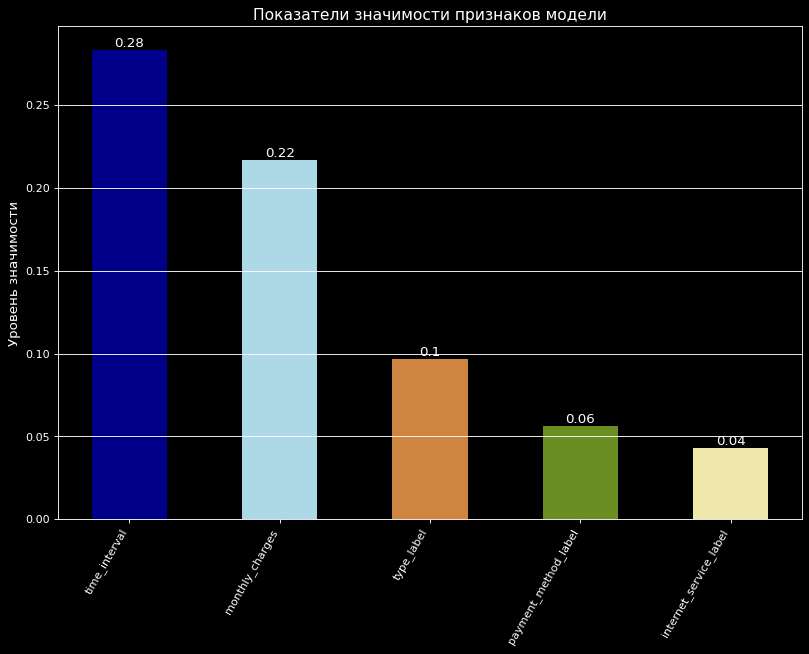

In [73]:
features_forest, best_features_forest = importance_and_auc_roc(RandomForestClassifier)

Модель:
 <class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC-ROC показатель модели из коробки:
 0.84
Таблица важности признаков для алгоритма


,feature,importance
0,internet_service_label,2.227899
1,monthly_charges,1.616155
2,type_of_main_traffic,1.034999
3,streaming_tv_yes,0.881329
4,time_interval,0.855718
5,streaming_movies_yes,0.824508
6,type_label,0.726485
7,multiple_lines_yes,0.513154
8,paperless_billing_yes,0.395715
9,device_protection_yes,0.271968


Наиболее важные признаки (все, что выше random_feature или по запросу):



,feature,importance
0,internet_service_label,2.227899
1,monthly_charges,1.616155
2,type_of_main_traffic,1.034999
3,streaming_tv_yes,0.881329
4,time_interval,0.855718
5,streaming_movies_yes,0.824508
6,type_label,0.726485
7,multiple_lines_yes,0.513154
8,paperless_billing_yes,0.395715
9,device_protection_yes,0.271968


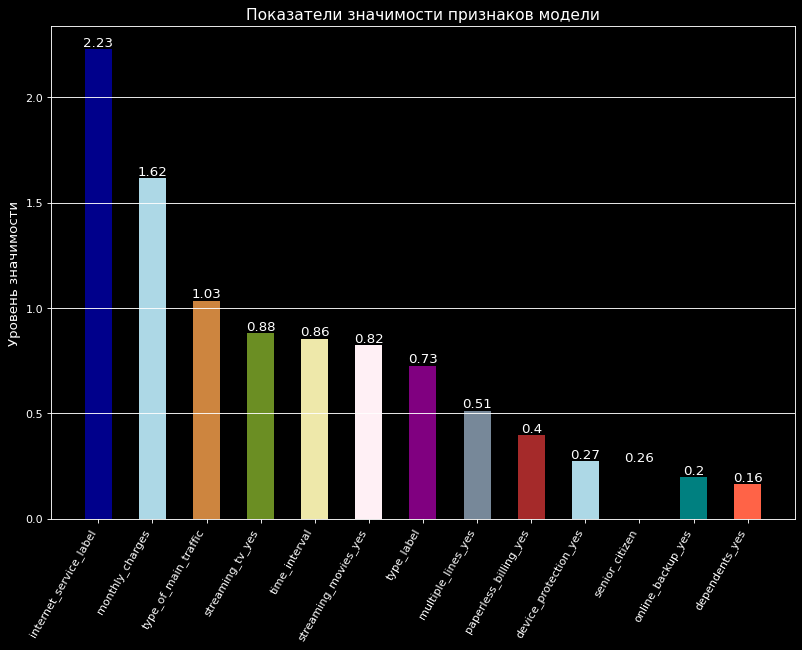

In [74]:
features_lr, best_features_lr = importance_and_auc_roc(LogisticRegression, 13)

Модель:
 <class 'lightgbm.sklearn.LGBMClassifier'>
AUC-ROC показатель модели из коробки:
 0.9
Таблица важности признаков для алгоритма


,feature,importance
0,time_interval,1358
1,monthly_charges,720
2,payment_method_label,138
3,random_feature,105
4,type_label,96
5,online_security_yes,56
6,partner_yes,54
7,dependents_yes,53
8,multiple_lines_yes,52
9,senior_citizen,51


Наиболее важные признаки (все, что выше random_feature или по запросу):



,feature,importance
0,time_interval,1358
1,monthly_charges,720
2,payment_method_label,138


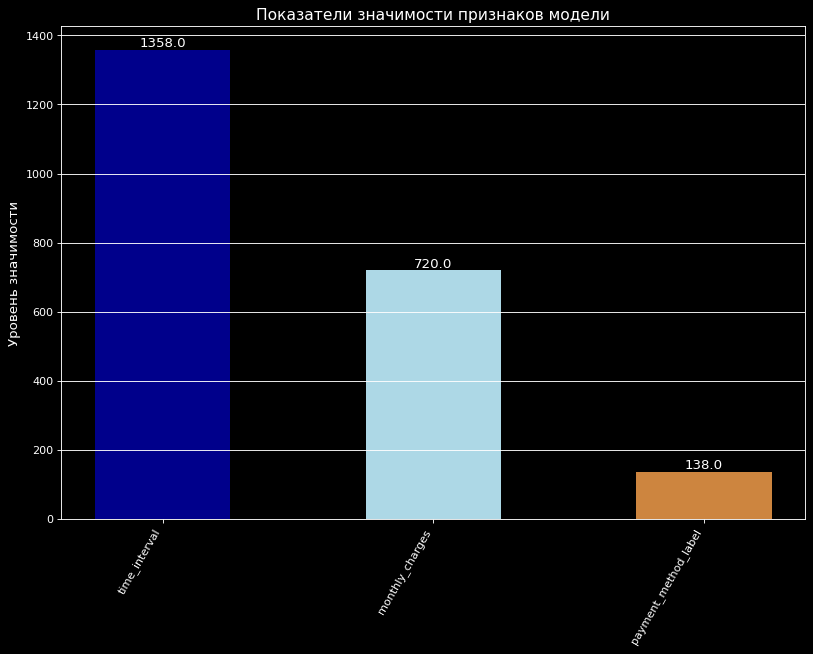

In [79]:
features_lgbmc, best_features_lgbmc = importance_and_auc_roc(LGBMClassifier)

В XGBClassifier отсечем все признаки, находящиеся ниже `random_feature`

Модель:
 <class 'xgboost.sklearn.XGBClassifier'>
AUC-ROC показатель модели из коробки:
 0.91
Таблица важности признаков для алгоритма


,feature,importance
0,internet_service_label,0.386118
1,type_label,0.274263
2,type_of_main_traffic,0.068791
3,time_interval,0.039043
4,streaming_tv_yes,0.024509
5,multiple_lines_yes,0.022848
6,paperless_billing_yes,0.019376
7,streaming_movies_yes,0.017779
8,online_security_yes,0.017342
9,tech_support_yes,0.017135


Наиболее важные признаки (все, что выше random_feature или по запросу):



,feature,importance
0,internet_service_label,0.386118
1,type_label,0.274263
2,type_of_main_traffic,0.068791
3,time_interval,0.039043
4,streaming_tv_yes,0.024509
5,multiple_lines_yes,0.022848
6,paperless_billing_yes,0.019376
7,streaming_movies_yes,0.017779
8,online_security_yes,0.017342
9,tech_support_yes,0.017135


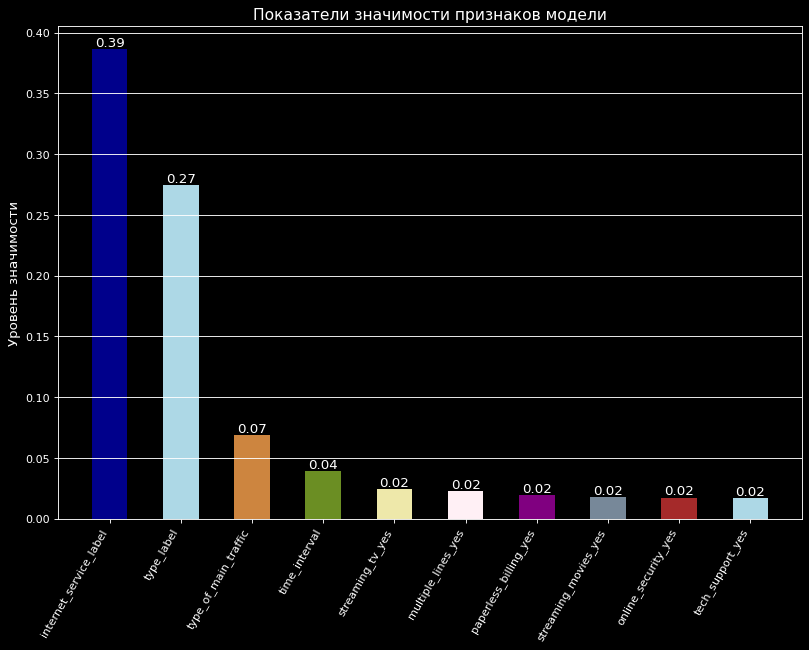

Наиболее важные признаки для алгоритма с помощью встроенной функции


<Figure size 1200x800 with 0 Axes>

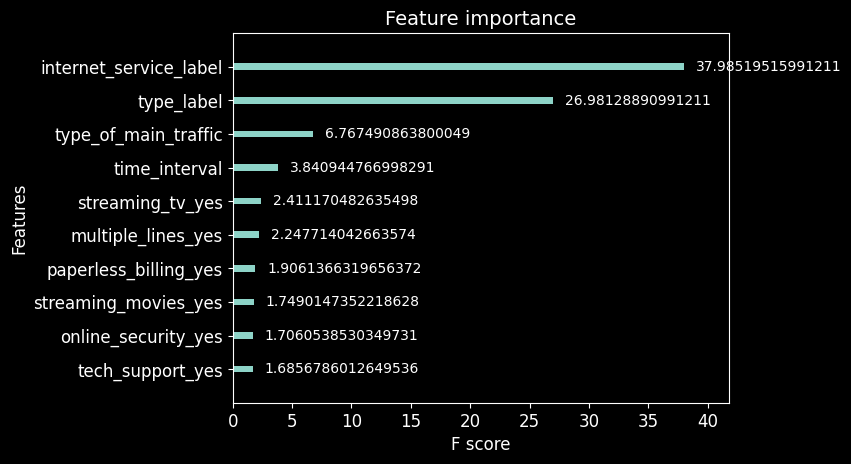

In [77]:
features_xgbc, best_features_xgbc = importance_and_auc_roc(XGBClassifier, 10)

А вот и наши признаки.

<a id='review_summary'></a>
## Выводы аналитической части

В ходе анализа, предобработки и исследования предоставленных данных были сделаны следующие выводы:
- дубликатов или пропусков найдено не было;
- проанализированы качественные и количественные признаки;
- выявлены статистически значимые признаки и проанализированы показатели влияния каждого на возможность/факт ухода клиента;
- отмечено, что не все пользуются сразу и интернетом, и телефонией, следовательно для компании это "потенциальные" клиента дополнительных услуг;
- в предоставленной базе данных присутствует дисбаланс классов; 
  
- **составлена модель потребительского поведения:**
    - наши клиенты - это люди преимущественно не пенсионныого возраста (84%) без детей (70%) (однако детский сегмент также присутствует) без доминирующего гендера и семейного положения, которые предпочитают оплачивать услуги ежемесячно (55%) безналичным расчетом (59%) и заинтересованы в использовании как интернета, так и телефонной связи (69%) - люди стремятся всегда к упрощению, в данном случае к удобному использованию одного вендора услуг. Помимо этого выявлено, что доп. услугами пользуется меньше половины всех клиентов (меньше ~35%), что объясняется их желанием **сыкономить**, однако стоит отметить интерес людей к медиатеке - стриминговому сервису и фильмам - и к доступу к облачному хранилищу.

- **выявлены слабые места в сервисе и клиентской базе:**
    - среди клиентов есть 22% тех, кто пользуется только телефонией компании - это потенциальные клиенты интернет услуг;
    - малый процент перехода клиентов на современный способ подключения интернета, всего `34,8%` текущих пользователей. Возможно люди хотели бы увидеть у себя дома более быстрый интернет трафик, будь такая возможность, однако для компании проведение подобной модернизации будет стоить внушительных денег - необходим узкий анализ с опросом клиентов, потенциально готовых к такому переходу и обновлению интернет маршрутизаторов.
    - самый большой отток клиентов связан со сферой предоставления интернета, `93,95%` процента растогнувших контракт людей пользовались данным сервисом:
        - `69,4%` среди растогнувших пользовались новой технологией подключения интернета Fiber optic. Возможно, есть проблемы с поставляемым оптоволоконным кабелем или частыми повреждениями на магистральном канале. **Средует уделить данной проблеме особое внимание**
        - такие дополнительные услуги, как стриминговое телевидение и доступ к каталогу фильмов при своей заинтересованности клиентами не способны удержать их, а возможно даже являются одной из неудовлетворительных причин оттока клиентов. По всей видимости данные сервисы нуждается в доработке и сборе дополнительного фидбека, так как 30% людей услуга не удерживает;
    - клиенты с помесячным способом оплаты чаще уходят (почти `88%` от всех клиентов с таким способом оплаты услуг) нежели те, кто платит сразу на год или даже на два. Возможно, следует рассмотреть вариант сезонных акций и скидок, привлекающих и подталкивающих людей оплатить услуги на большее время. Можно попробовать на тестовой группе решение с 3-х месячным и 6-м вариантом с логикой "Заплатил, забыл, оценил и продлил". Что-нибудь в подобном духе :)
    - среди ушедших большой процент людей (`57%`), кто оплачивал услуги через электронные чеки, что является самым популярным способом. Следует рассмотреть варианты оптимизации и привлекательности данного способа оплаты;
   
- **выявлены сильные места в сервисе:**
    - наличие этих дополнительных услуг способствует удержанию клиентов, а значит их довольствию и потенциальному развитию вовлеченности:
        - блокировка небезопасных сайтов - в два раза снизила уход клиентов, однако только 15% расторгнувших контракт использовали данный сервис;
        - тех. поддержка - в два раза снизила уход клиентов, однако только 17% расторгнувших контракт использовали данный сервис.
        
- **найдена интересная закономерность для бизнеса в 2019-2020 годах:**
    - наблюдается скачок активности прихода в начале осени 2019 года и ухода к новому 2020 году. Видимо в этот период проходила агрессивная маркетинговая компания по привлечению новых клиентов, но на тот момент не способна была их удержать по тем или иным причинам.
    - почти все ушедшие в этот период так и не попробовали дополнительные услуги
    - все они пользовались интернет+телефон
    - для статистики эти клиенты использовали и DLS, и оптический кабель
    - это были одинокие люде не пенсионного возраста, как мужчины так и женщины, без детей. Есть подозрение, что они были относительно молодые, заинтересовавшиеся выгодным предложением-акцией. Контенгент людей, находящийся постоянно в поиске наиболее выгодного предложения низкая цена+высокое качество
    
- **найдена интересная закономерность для бизнеса:**
    - клиенты, пришедшие в компанию ближе к концу месяца с большой долей вероятности вскоре ее покинут. Возможно дело в агрессивной маркетинговой компании, предлагающей выгодные условия новым клиентам, но только на время.

<a id='models'></a>
## **III. Построение моделей**

Пространство гиперпараметров для поиска

Для бустинга: меньше глубина, больше деревьев

In [80]:
space_boost = {'max_depth': hp.choice ('max_depth', np.arange(1, 15+1, dtype=int)),
               'n_estimators' : hp.choice ('n_estimators', np.arange(1, 200, dtype=int)),
               'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        }

Для случайного леса: больше глубина, меньше деревьев.

In [81]:
space_forest = {'max_depth': hp.choice ('max_depth', np.arange(1, 100+1, dtype=int)),
        'n_estimators' : hp.choice ('n_estimators', np.arange(1, 40, dtype=int)),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        }

<a id='forest'></a>
### 1. Модель «Случайный лес»

In [82]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_forest):
        
        model_opt = RandomForestClassifier(random_state=random_state, 
                                      max_depth = space_forest['max_depth'], 
                                      n_estimators = space_forest['n_estimators'],
                                      criterion = 'entropy',
                                      min_samples_split = space_forest['min_samples_split'],
                                      class_weight = 'balanced'
                                     )
    
        model_opt.fit(features_train, target_train)
        
        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=10).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }
    
    trials = Trials()
    best = fmin(fn= objective,
            space= space_forest,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials,
            show_progressbar=True)
    
    print(best)

    # засекаем время на обучение лучшей модели
    start_time = time.time()
    
    best_model = RandomForestClassifier(random_state=random_state, 
                                        max_depth = best['max_depth'], 
                                        n_estimators = best['n_estimators'],
                                        criterion = 'entropy',
                                        min_samples_split = best['min_samples_split'],
                                        class_weight = 'balanced'
                                       )

    best_model.fit(features_train, target_train)
        
    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=10).mean(), 2)

    model_time = round((time.time() - start_time), 5)
    
    print(f'Время выполнения обучения c лучшими параметрами составляет {model_time:.3f} секунд')

    return best, model_time, roc_auc_best, best_model

In [83]:
best_forest_param, best_forest_time, best_forest_roc_auc, best_forest_model = (
    best_par_hyperopt(features_forest, target))

print('Значение roc_auc равно', best_forest_roc_auc)

100%|███████████████████| 100/100 [00:39<00:00,  2.54trial/s, best loss: -0.867]
{'max_depth': 94, 'min_samples_split': 0.01684013778163118, 'n_estimators': 26}
Время выполнения обучения c лучшими параметрами составляет 0.855 секунд
Значение roc_auc равно 0.87


```
Результаты локальной машины:
100%|██████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83trial/s, best loss: -0.862]
{'max_depth': 51, 'min_samples_split': 0.009670655708615875, 'n_estimators': 38}
Время выполнения обучения c лучшими параметрами составляет 1.486 секунд
Значение roc_auc равно 0.86
```

In [84]:
features.shape[1]

18

In [85]:
features_forest.shape[1]

5

<a id='regression'></a>
### 2. Модель «Логистическая регрессия»

In [86]:
features_lr.head(3)

,internet_service_label,monthly_charges,type_of_main_traffic,streaming_tv_yes,time_interval,streaming_movies_yes,type_label,multiple_lines_yes,paperless_billing_yes,device_protection_yes,senior_citizen,online_backup_yes,dependents_yes
5040,1,1.059650,2,1,-0.511745,0,0,1,0,0,0,1,1
6366,0,0.108413,2,0,1.276319,1,2,0,1,1,0,1,0
3639,1,1.183144,2,1,1.112069,1,1,1,1,1,1,0,0


In [87]:
features_lr_bi = features_lr.drop(columns = ['monthly_charges', 'streaming_movies_yes'], axis = 1)

interval columns not set, guessing: ['internet_service_label', 'streaming_tv_yes', 'time_interval', 'multiple_lines_yes', 'paperless_billing_yes', 'device_protection_yes', 'senior_citizen', 'online_backup_yes', 'dependents_yes', 'type_label_0', 'type_label_1', 'type_label_2', 'type_of_main_traffic_0', 'type_of_main_traffic_1', 'type_of_main_traffic_2']
interval columns not set, guessing: ['internet_service_label', 'streaming_tv_yes', 'time_interval', 'multiple_lines_yes', 'paperless_billing_yes', 'device_protection_yes', 'senior_citizen', 'online_backup_yes', 'dependents_yes', 'type_label_0', 'type_label_1', 'type_label_2', 'type_of_main_traffic_0', 'type_of_main_traffic_1', 'type_of_main_traffic_2']
interval columns not set, guessing: ['internet_service_label', 'streaming_tv_yes', 'time_interval', 'multiple_lines_yes', 'paperless_billing_yes', 'device_protection_yes', 'senior_citizen', 'online_backup_yes', 'dependents_yes', 'type_label_0', 'type_label_1', 'type_label_2', 'type_of_main

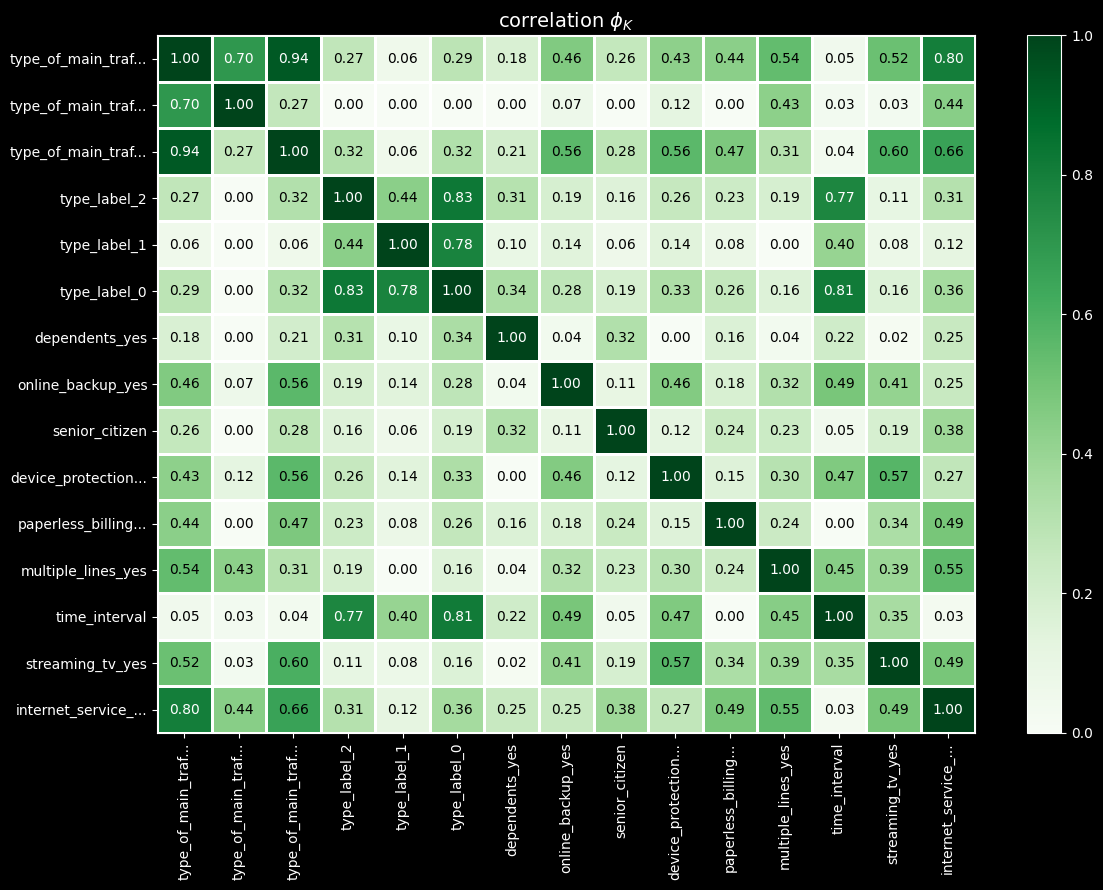

In [91]:
plot_correlation_matrix(features_lr_bi.phik_matrix().values, 
                        x_labels=features_lr_bi.phik_matrix().columns, 
                        y_labels=features_lr_bi.phik_matrix().index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.0, 
                        figsize=(12, 9))
plt.tight_layout()

In [93]:
features_lr_bi = pd.get_dummies(features_lr_bi, columns=['type_label', 'type_of_main_traffic', ], drop_first=False)
features_lr_bi.head(3)

KeyError: "None of [Index(['type_label', 'type_of_main_traffic'], dtype='object')] are in the [columns]"

In [94]:
model_lr = LogisticRegression(random_state=random_state)

params = {'C': [0.1, 0.2, 0.5, 0.7, 1, 2, 5, 10, 15, 20]}

for i in tqdm(range(len(list(params.get('C'))))):
    g_cv_lr = GridSearchCV(estimator=model_lr, 
                           param_grid=params, 
                           scoring='roc_auc',
                           cv=10,
                           n_jobs=1,
                           refit=False)
    
    g_cv_lr.fit(features_lr_bi, target)

best_lr_param = g_cv_lr.best_params_


# засекаем время на обучение лучшей модели
start_time = time.time()
best_g_cv_lr_model = LogisticRegression(random_state=random_state,
                                        solver='lbfgs',
                                        C=g_cv_lr.best_params_.get('C'),
                                        class_weight = 'balanced').fit(features_lr_bi, target)

best_lr_roc_auc = round(g_cv_lr.best_score_, 2)

best_lr_time = round((time.time() - start_time), 5)

print(best_lr_param)

print(f'Время выполнения обучения c лучшими параметрами составляет {best_lr_time:.3f} секунд')
print('Значение roc_auc равно', best_lr_roc_auc)

  0%|          | 0/10 [00:00<?, ?it/s]

{'C': 0.7}
Время выполнения обучения c лучшими параметрами составляет 0.034 секунд
Значение roc_auc равно 0.84


```
Результаты локальной машины:
100% 10/10 [00:10<00:00, 1.02s/it]
{'C': 20}
Время выполнения обучения c лучшими параметрами составляет 0.010 секунд
Значение roc_auc равно 0.84
```

<a id='lgbm'></a>
### 3. Модель LightGBM

In [96]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_boost):

        model_opt = LGBMClassifier(random_state=random_state, 
                                      max_depth = space_boost['max_depth'], 
                                      n_estimators = space_boost['n_estimators'],
                                     )

        model_opt.fit(features_train, target_train, verbose=0)

        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=10).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }

    trials = Trials()
    best = fmin(fn= objective,
            space= space_boost,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials,
            show_progressbar=True)

    print(best)

    # засекаем время на обучение лучшей модели
    start_time = time.time()

    #лучшую модель будем обучать уже на объединенной обучающей и валидационной
    best_model = LGBMClassifier(random_state=random_state, 
                                   max_depth = best['max_depth'],
                                   n_estimators = best['n_estimators']
                                  )

    best_model.fit(features_train, target_train, verbose=0)

    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=10).mean(), 2)

    model_time = round((time.time() - start_time), 5)

    print(f'Время выполнения обучения c лучшими параметрами составляет {model_time:.3f} секунд')

    return best, model_time, roc_auc_best, best_model

In [97]:
best_lgbmc_param, best_lgbmc_time, best_lgbmc_roc_auc, best_lgbmc_model = (
    best_par_hyperopt(features_lgbmc, target))

print('Значение roc_auc равно', best_lgbmc_roc_auc)

100%|███████████████████| 100/100 [22:06<00:00, 13.26s/trial, best loss: -0.904]
{'max_depth': 13, 'min_samples_split': 0.8354624102261666, 'n_estimators': 184}
Время выполнения обучения c лучшими параметрами составляет 16.707 секунд
Значение roc_auc равно 0.9


```
Результаты локальной машины:
100%|██████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: -0.904]
{'max_depth': 9, 'min_samples_split': 0.255258238545897, 'n_estimators': 187}
Время выполнения обучения c лучшими параметрами составляет 1.697 секунд
Значение roc_auc равно 0.9
```

<a id='xgboost'></a>
### 4. Модель XGBoost

In [98]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_boost):
        
        model_opt = XGBClassifier(random_state=random_state, 
                                      max_depth = space_boost['max_depth'], 
                                      n_estimators = space_boost['n_estimators'],
                                      eval_metric='logloss'
                                     )
    
        model_opt.fit(features_train, target_train)
        
        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=10).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }
    
    trials = Trials()
    best = fmin(fn= objective,
            space= space_boost,
            algo= tpe.suggest,
            max_evals = 50,
            trials= trials,
            show_progressbar=True)
    
    print(best)

    # засекаем время на обучение лучшей модели
    start_time = time.time()
    
    best_model = XGBClassifier(random_state=random_state, 
                                   max_depth = best['max_depth'],
                                   eval_metric='logloss',
                                   n_estimators = best['n_estimators']
                                  )
    
    best_model.fit(features_train, target_train)
    

    
    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=10).mean(), 2)

    model_time = round((time.time() - start_time), 5)
    
    print(f'Время выполнения обучения c лучшими параметрами составляет {model_time:.3f} секунд')

    return best, model_time, roc_auc_best, best_model

In [99]:
best_xgbc_param, best_xgbc_time, best_xgbc_roc_auc, best_xgbc_model = (
    best_par_hyperopt(features_xgbc, target))

print('Значение roc_auc равно', best_xgbc_roc_auc)

100%|█████████████████████| 50/50 [05:53<00:00,  7.06s/trial, best loss: -0.934]
{'max_depth': 3, 'min_samples_split': 0.20898182704895873, 'n_estimators': 181}
Время выполнения обучения c лучшими параметрами составляет 5.958 секунд
Значение roc_auc равно 0.93


```
Результаты локальной машины:
100%|████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.91s/trial, best loss: -0.935]
{'max_depth': 3, 'min_samples_split': 0.9945975351663447, 'n_estimators': 172}
Время выполнения обучения c лучшими параметрами составляет 1.478 секунд
Значение roc_auc равно 0.93
```

### Промежуточный итог

Получили следующие данные по лучшим моделям на обучении

In [100]:
# добавим все модели в словарь для быстрого доступа к названию и самой модели
models = {'Случайный лес' : best_forest_model,
          'Логистическая регрессия' : best_g_cv_lr_model,
          'LGBMClassifier' : best_lgbmc_model,
          'XGBClassifier' : best_xgbc_model
         }

models_description = [
    ['Случайный лес',best_forest_roc_auc, best_forest_time, best_forest_param],
    ['Логистическая регрессия', best_lr_roc_auc, best_lr_time, best_lr_param],
    ['LGBMClassifier', best_lgbmc_roc_auc, best_lgbmc_time, best_lgbmc_param],
    ['XGBClassifier', best_xgbc_roc_auc, best_xgbc_time, best_xgbc_param]
]

columns_models_description = ['Модель', 'Лучшее качество roc_auc при обучении', 
                              'Время выполнения оптимального параметра, сек.', 'Лучшие гиперпараметры']

models_summary = pd.DataFrame(data=models_description, columns=columns_models_description)
pd.set_option('display.max_colwidth', None)
models_summary.sort_values(by='Лучшее качество roc_auc при обучении', ascending=False)

,Модель,Лучшее качество roc_auc при обучении,"Время выполнения оптимального параметра, сек.",Лучшие гиперпараметры
3,XGBClassifier,0.93,5.95836,"{'max_depth': 3, 'min_samples_split': 0.20898182704895873, 'n_estimators': 181}"
2,LGBMClassifier,0.90,16.70739,"{'max_depth': 13, 'min_samples_split': 0.8354624102261666, 'n_estimators': 184}"
0,Случайный лес,0.87,0.85458,"{'max_depth': 94, 'min_samples_split': 0.01684013778163118, 'n_estimators': 26}"
1,Логистическая регрессия,0.84,0.03417,{'C': 0.7}


Итого лучшей моделью по итогу обучения является `XGBClassifier` с качеством `roc_auc 0.93`, но довольно длительным временем обучения. на больших объемах данных было бы неплохо потестить и `LGBMClassifier` с незначительно меньшим качеством, однако существенно быстрее обучающейся и менее требовательной к вычислительным мощностям.

In [101]:
best_model_name = 'XGBClassifier'

best_model = models.get(best_model_name)

best_model_summary = models_summary[models_summary['Модель'] == best_model_name]
best_model_summary

,Модель,Лучшее качество roc_auc при обучении,"Время выполнения оптимального параметра, сек.",Лучшие гиперпараметры
3,XGBClassifier,0.93,5.95836,"{'max_depth': 3, 'min_samples_split': 0.20898182704895873, 'n_estimators': 181}"


<a id='test'></a>
### **5. Проверка лучшей модели на тестовой выборке**

Проверим нашу лучшую модель на тестовой выбоке, чтобы убедиться в ее качестве

In [102]:
roc_auc_test = round(cross_val_score(best_model, features_test, target_test, scoring='roc_auc', cv=10).mean(), 3)

print(f'roc_auc модели {models_description[best_model_summary.index[0]][0]} на тестовой выборке:', roc_auc_test)
    
print()

# добавим новый столбец в выводной таблице по лучшей модели
best_model_summary['Качество при тесте'] = roc_auc_test

roc_auc модели XGBClassifier на тестовой выборке: 0.874



```
Результаты локальной машины:

roc_auc модели XGBClassifier на тестовой выборке: 0.876
```

Выведем еще раз итоговую таблицу

In [103]:
best_model_summary

,Модель,Лучшее качество roc_auc при обучении,"Время выполнения оптимального параметра, сек.",Лучшие гиперпараметры,Качество при тесте
3,XGBClassifier,0.93,5.95836,"{'max_depth': 3, 'min_samples_split': 0.20898182704895873, 'n_estimators': 181}",0.874


Построим матрицу ошибок

In [104]:
# строим матрицу ошибок лучшей модели

predict = best_model.predict(features_test[list(features_xgbc.columns)])
matrix = confusion_matrix(target_test, predict)
print('\033[4m\033[1m\033[31m{}\033[0m\n'
      .format('Матрица ошибок лучшей модели:'), matrix)

Матрица ошибок лучшей модели:
 [[1217   49]
 [ 181  311]]


Также построим ROC-кривую. По горизонтали нанесём долю ложноположительных ответов (FPR), а по вертикали — долю истинно положительных ответов (TPR). Построим кривую ошибок для нашей лучше модели `XGBClassifier` и сравним ее с моделью, которая всегда отвечает случайно (прямая диагональ). Соответственно чем наша кривая выше, тем больше значение полнота TPR и лучше качество модели.

In [105]:
def roc_curve_plot(model, model_name, features_model):
    probabilities_test = model.predict_proba(features_test[list(features_model.columns)])
    probabilities_one_test = probabilities_test[:, 1]

    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    plt.figure(figsize=[12,9])

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlabel('False Positive Rate', fontsize = 12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.title(f'ROC-кривая {model_name}', fontsize = 14)
    plt.legend([model_name, 'Random_model'], fontsize=13)

    plt.show()

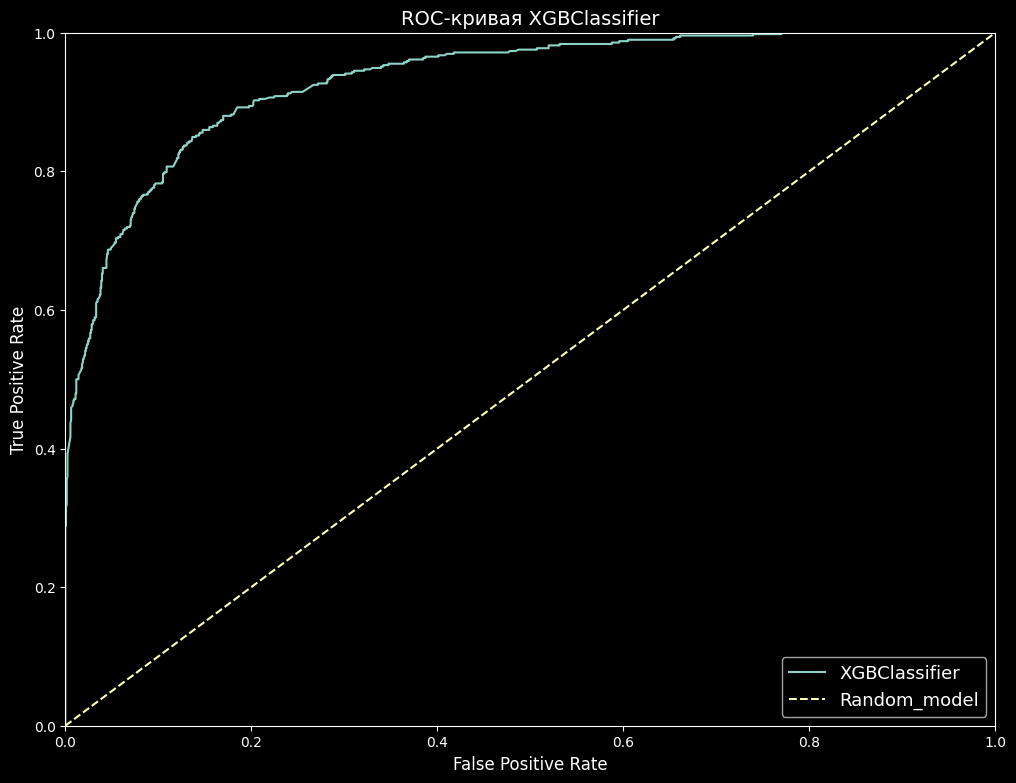

In [106]:
roc_curve_plot(best_model, best_model_name, features_xgbc)

<a id='aruok?'></a>
### **6. Проверка модели на вменяемость**

In [107]:
features = abs(features.drop(columns=['random_feature'], axis=1))
features_test_ok = abs(features_test)

#### **6.1 DummyClassifier**

Также проверим модель на адекватность, сравнив со случайными результатами, которые игнорируют правило входных данных. И если модель ведет себя лучше, то значит она может извлекать какой-то сигнал из данных и имеет предсказательную силу.
Для этого воспользуемся `sklearn.dummy.DummyClassifier`

In [108]:
dummy_cls = DummyClassifier(strategy="uniform")
dummy_cls.fit(features, target)

dummy_roc_auc = round(cross_val_score(dummy_cls, features_test_ok, target_test, scoring='roc_auc', cv=10).mean(), 2)

print(f'roc_auc DummyClassifier: {dummy_roc_auc}')

roc_auc DummyClassifier: 0.5


#### **6.2 Наивный Байесовский классификатор**

Инициализируем Наивный байесовский классификатор и прогоним наши данные

In [109]:
model_bayes = MultinomialNB().fit(features, target)

bayes_roc_auc = round(cross_val_score(model_bayes, features_test_ok, target_test, scoring='roc_auc', cv=10).mean(), 2)

print(f'roc_auc BayesClassifier: {bayes_roc_auc}')

roc_auc BayesClassifier: 0.82


<a id='models_summary'></a>
### Выводы раздела построения моделей

По итогу проверки на тестовых данных:
* наша выбранная модель XGBClassifier показала лучшее качество `roc_auc 0.861` на тесте при оптимальных временных затратах и гиперпараметрах: 
    - `max_depth`: 3,
    - `min_samples_split`: 0.2625708558380374, 
    - `n_estimators`: 155;
* метрики `XGBClassifier` и `LGBMClassifier` на обучении не сильно отличаются друг от друга, однако второй алгоритм учится быстрее, соответственно и ресурсов ест меньше - одни плюсы; нужно рассматривать обе модели как потенциально презентуемые, так как на больших объемах данных для бизнеса может быть выгоднее использовать `LGBMClassifier`
* результат случайной модели на тестовой выборке равен примерно 50%, что в сравнении с выбранной нами доказывает вменяемость нашей рассмотренной модели
* сравнили результат точности предсказания нашей лучшей модели с Наивным байесовским классификатором и увидели, что мы получили очень неплохой результат на выбранной модели.

<a id='final_summary'></a>
## **IV. Итоги исследования**

В ходе анализа, предобработки и исследования предоставленных данных были сделаны следующие выводы:
- дубликатов или пропусков найдено не было;
- проанализированы качественные и количественные признаки;
- выявлены статистически значимые признаки и проанализированы показатели влияния каждого на возможность/факт ухода клиента;
- отмечено, что не все пользуются сразу и интернетом, и телефонией, следовательно для компании это "потенциальные" клиента дополнительных услуг;
- в предоставленной базе данных присутствует дисбаланс классов; 
--- 
- <font color=#008B8B> **составлена модель потребительского поведения:** </font>
    - наши клиенты - это люди преимущественно не пенсионныого возраста (84%) без детей (70%) (однако детский сегмент также присутствует) без доминирующего гендера и семейного положения, которые предпочитают оплачивать услуги ежемесячно (55%) безналичным расчетом (59%) и заинтересованы в использовании как интернета, так и телефонной связи (69%) - люди стремятся всегда к упрощению, в данном случае к удобному использованию одного вендора услуг. Помимо этого выявлено, что доп. услугами пользуется меньше половины всех клиентов (меньше ~35%), что объясняется их желанием **сыкономить**, однако стоит отметить интерес людей к медиатеке - стриминговому сервису и фильмам - и к доступу к облачному хранилищу.
---
- <font color=#DC143C> **выявлены слабые места в сервисе и клиентской базе:** </font>
    - среди клиентов есть 22% тех, кто пользуется только телефонией компании - это потенциальные клиенты интернет услуг;
    - малый процент перехода клиентов на современный способ подключения интернета, всего `34,8%` текущих пользователей. Возможно люди хотели бы увидеть у себя дома более быстрый интернет трафик, будь такая возможность, однако для компании проведение подобной модернизации будет стоить внушительных денег - необходим узкий анализ с опросом клиентов, потенциально готовых к такому переходу и обновлению интернет маршрутизаторов.
    - самый большой отток клиентов связан со сферой предоставления интернета, `93,95%` процента растогнувших контракт людей пользовались данным сервисом:
        - `69,4%` среди растогнувших пользовались новой технологией подключения интернета Fiber optic. Возможно, есть проблемы с поставляемым оптоволоконным кабелем или частыми повреждениями на магистральном канале. **Средует уделить данной проблеме особое внимание**
        - такие дополнительные услуги, как стриминговое телевидение и доступ к каталогу фильмов при своей заинтересованности клиентами не способны удержать их, а возможно даже являются одной из неудовлетворительных причин оттока клиентов. По всей видимости данные сервисы нуждается в доработке и сборе дополнительного фидбека, так как 30% людей услуга не удерживает;
    - клиенты с помесячным способом оплаты чаще уходят (почти `88%` от всех клиентов с таким способом оплаты услуг) нежели те, кто платит сразу на год или даже на два. Возможно, следует рассмотреть вариант сезонных акций и скидок, привлекающих и подталкивающих людей оплатить услуги на большее время. Можно попробовать на тестовой группе решение с 3-х месячным и 6-м вариантом с логикой "Заплатил, забыл, оценил и продлил". Что-нибудь в подобном духе :)
    - среди ушедших большой процент людей (`57%`), кто оплачивал услуги через электронные чеки, что является самым популярным способом. Следует рассмотреть варианты оптимизации и привлекательности данного способа оплаты;
---  
- <font color='green'> **выявлены сильные места в сервисе:** </font>
    - наличие этих дополнительных услуг способствует удержанию клиентов, а значит их довольствию и потенциальному развитию вовлеченности:
        - блокировка небезопасных сайтов - в два раза снизила уход клиентов, однако только 15% расторгнувших контракт использовали данный сервис;
        - тех. поддержка - в два раза снизила уход клиентов, однако только 17% расторгнувших контракт использовали данный сервис.
---     
- <font color=#FFD700> **найдена интересная закономерность для бизнеса в 2019-2020 годах:** </font>
    - наблюдается скачок активности прихода в начале осени 2019 года и ухода к новому 2020 году. Видимо в этот период проходила агрессивная маркетинговая компания по привлечению новых клиентов, но на тот момент не способна была их удержать по тем или иным причинам.
    - почти все ушедшие в этот период так и не попробовали дополнительные услуги
    - все они пользовались интернет+телефон
    - для статистики эти клиенты использовали и DLS, и оптический кабель
    - это были одинокие люде не пенсионного возраста, как мужчины так и женщины, без детей. Есть подозрение, что они были относительно молодые, заинтересовавшиеся выгодным предложением-акцией. Контенгент людей, находящийся постоянно в поиске наиболее выгодного предложения низкая цена+высокое качество
--- 
- <font color=#FFD700> **найдена интересная закономерность для бизнеса:** </font>
    - клиенты, пришедшие в компанию ближе к концу месяца с большой долей вероятности вскоре ее покинут. Возможно дело в агрессивной маркетинговой компании, предлагающей выгодные условия новым клиентам, но только на время.

На основании обработанных данных мы создали несколько моделей, подобрали оптимальные гиперпараметры, выбрали лучшую и проверили ее на тестовой выборке. И вот что у нас получилось:

In [110]:
best_model_summary

,Модель,Лучшее качество roc_auc при обучении,"Время выполнения оптимального параметра, сек.",Лучшие гиперпараметры,Качество при тесте
3,XGBClassifier,0.93,5.95836,"{'max_depth': 3, 'min_samples_split': 0.20898182704895873, 'n_estimators': 181}",0.874


Фаворитом метрики `roc_auc является` **XGBClassifier**, однако стоит также протестировать `LGBMClassifier` на больших объемах данных, так как с точки зрения скорости и затрат вычислительной мощности она может оказаться более перспективна для бизнеса при незначительном снижении качества.

<a id='report'></a> 
# V. Отчёт по проекту «Определение потенциально уходящего клиента телеком-компании»


В данной работе мы поставили себе план и не сильно от него отклонялись. Выполненые шаги по плану были:

**1. Изучили полученные данные и предобработали их:**

- определили целевой признак - факт ухода клиента по дате разрыва контракта;
- изменили необходимые типы данных (begin_date, end_date к формату даты, а total_charges к формату float);
- создали временной признак: количество дней, которое человек является клиентом компании;
- проверили данные на дубликаты или пропуски - в первоначальных таблицах найдены не были; 
- категориальные признаки были преобразованы в бинарный вид и числовой вид с помощью метода OHE и порядкового кодирования для удобства дальнейшего обучения моделей классификации;
- объединили данные в один датасет, для удобства работы;
- заполнили пропущенные значения после объединения и заменили их в соответствии с использованием тех или иных услуг;
- убрали из датасета объекты (клиентов) с минимальным временем клиентства - где месяц подписания контракта соответствует месяцу выгрузки 2 февраля 2020.
---
**2. Провели исследовательский анализ данных:**

- проанализировали качественные и количественные признаки, исследовали их корреляцию и влияние как на целевой признак, так и между собой. 
- сравнили распределения величин и сделали первичные выводы по модели потребительского поведения клиентов;
- оценили влияние каждого признака на возможность/факт ухода клиента;
- создали дополнительный признак, показывающий какими основными услугами пользуются клиенты;
- изучена статистическая аномалия осени 2019 - зимы 2020, где был большой отток людей с небольшой длительностью клиентства из-за маркетинговой кампании; 
- создали типичный профиль клиента компании;
- удалили из данных признаки, не оказывающие никакого влияния на ответ на интересующий нас вопрос или дублирующие;
- провели масштабирование количественных признаков;
- разделили данные на выборки (75% обучающую и 25% тестовую);
- создали случайный признак random_state для отсева незначительных признаков;
- обучили модели машинного обучения "из коробки" - случаный лес, логистическая регрессия и модели бустинка - для выявления наиболее значимых признаков и сформировали для каждой свой датасет признаков для обучения.

**Выводы получившиеся из исследовательского анализа**

- <font color=#008B8B> **составлена модель потребительского поведения:** </font>
    - наши клиенты - это люди преимущественно не пенсионныого возраста (84%) без детей (70%) (однако детский сегмент также присутствует) без доминирующего гендера и семейного положения, которые предпочитают оплачивать услуги ежемесячно (55%) безналичным расчетом (59%) и заинтересованы в использовании как интернета, так и телефонной связи (69%) - люди стремятся всегда к упрощению, в данном случае к удобному использованию одного вендора услуг. Помимо этого выявлено, что доп. услугами пользуется меньше половины всех клиентов (меньше ~35%), что объясняется их желанием **сыкономить**, однако стоит отметить интерес людей к медиатеке - стриминговому сервису и фильмам - и к доступу к облачному хранилищу.

- <font color=#DC143C> **выявлены слабые места в сервисе и клиентской базе:** </font>
    - среди клиентов есть 22% тех, кто пользуется только телефонией компании - это потенциальные клиенты интернет услуг;
    - малый процент перехода клиентов на современный способ подключения интернета, всего `34,8%` текущих пользователей. Возможно люди хотели бы увидеть у себя дома более быстрый интернет трафик, будь такая возможность, однако для компании проведение подобной модернизации будет стоить внушительных денег - необходим узкий анализ с опросом клиентов, потенциально готовых к такому переходу и обновлению интернет маршрутизаторов.
    - самый большой отток клиентов связан со сферой предоставления интернета, `93,95%` процента растогнувших контракт людей пользовались данным сервисом:
        - `69,4%` среди растогнувших пользовались новой технологией подключения интернета Fiber optic. Возможно, есть проблемы с поставляемым оптоволоконным кабелем или частыми повреждениями на магистральном канале. **Средует уделить данной проблеме особое внимание**
        - такие дополнительные услуги, как стриминговое телевидение и доступ к каталогу фильмов при своей заинтересованности клиентами не способны удержать их, а возможно даже являются одной из неудовлетворительных причин оттока клиентов. По всей видимости данные сервисы нуждается в доработке и сборе дополнительного фидбека, так как 30% людей услуга не удерживает;
    - клиенты с помесячным способом оплаты чаще уходят (почти `88%` от всех клиентов с таким способом оплаты услуг) нежели те, кто платит сразу на год или даже на два. Возможно, следует рассмотреть вариант сезонных акций и скидок, привлекающих и подталкивающих людей оплатить услуги на большее время. Можно попробовать на тестовой группе решение с 3-х месячным и 6-м вариантом с логикой "Заплатил, забыл, оценил и продлил".
    - среди ушедших большой процент людей (`57%`), кто оплачивал услуги через электронные чеки, что является самым популярным способом. Следует рассмотреть варианты оптимизации и привлекательности данного способа оплаты;

- <font color='green'> **выявлены сильные места в сервисе:** </font>
    - наличие этих дополнительных услуг способствует удержанию клиентов, а значит их довольствию и потенциальному развитию вовлеченности:
        - блокировка небезопасных сайтов - в два раза снизила уход клиентов, однако только 15% расторгнувших контракт использовали данный сервис;
        - тех. поддержка - в два раза снизила уход клиентов, однако только 17% расторгнувших контракт использовали данный сервис.

- <font color=#FFD700> **найдена интересная закономерность для бизнеса в 2019-2020 годах:** </font>
    - наблюдается скачок активности прихода в начале осени 2019 года и ухода к новому 2020 году. Видимо в этот период проходила агрессивная маркетинговая компания по привлечению новых клиентов, но на тот момент не способна была их удержать по тем или иным причинам.
    - почти все ушедшие в этот период так и не попробовали дополнительные услуги
    - все они пользовались интернет+телефон
    - для статистики эти клиенты использовали и DLS, и оптический кабель
    - это были одинокие люде не пенсионного возраста, как мужчины так и женщины, без детей. Есть подозрение, что они были относительно молодые, заинтересовавшиеся выгодным предложением-акцией. Контенгент людей, находящийся постоянно в поиске наиболее выгодного предложения низкая цена+высокое качество

- <font color=#FFD700> **найдена интересная закономерность для бизнеса:** </font>
    - клиенты, пришедшие в компанию ближе к концу месяца с большой долей вероятности вскоре ее покинут. Возможно дело в агрессивной маркетинговой компании, предлагающей выгодные условия новым клиентам, но только на время.
---
**3. В части построения моделей машинного обучения:**
- на подготовленных датасетах признаков подобрали гиперпараметры для каждой модели, при которых достигается лучшие показатели метрики roc_auc;
- проанализировали результаты работы наших моделей;
- лучшей моделью по итогу обучения выбрали `XGBClassifier` с качеством roc_auc`0.93` и следующим набором параметров
    - `max_depth`: 3,
    - `min_samples_split`: 0.2625708558380374, 
    - `n_estimators`: 155;
- прогнали нашу лучшую модель через тестовую выборку для оценки ее способности правильного предсказания и получили результат roc_auc`0.876`
- сравнили получившуюся модель с Наивным Байесовским классификатором и DummyClassifier и сделали следующие выводы:
    - результат случайной модели на тестовой выборке равен примерно 50%, что в сравнении с выбранной нами доказывает вменяемость нашей рассмотренной модели
    - результат точности предсказания нашей лучшей модели в сравнении с Наивным байесовским классификатором оказался выше, что свидетельствует об очень неплохом результат выбранной модели;

Результаты лучшей модели представлены в таблице ниже.

In [111]:
best_model_summary

,Модель,Лучшее качество roc_auc при обучении,"Время выполнения оптимального параметра, сек.",Лучшие гиперпараметры,Качество при тесте
3,XGBClassifier,0.93,5.95836,"{'max_depth': 3, 'min_samples_split': 0.20898182704895873, 'n_estimators': 181}",0.874


Модель обучена на следующем списке признаков с показателем их важности для модели:

,feature,importance
0,internet_service_label,0.386118
1,type_label,0.274263
2,type_of_main_traffic,0.068791
3,time_interval,0.039043
4,streaming_tv_yes,0.024509
5,multiple_lines_yes,0.022848
6,paperless_billing_yes,0.019376
7,streaming_movies_yes,0.017779
8,online_security_yes,0.017342
9,tech_support_yes,0.017135


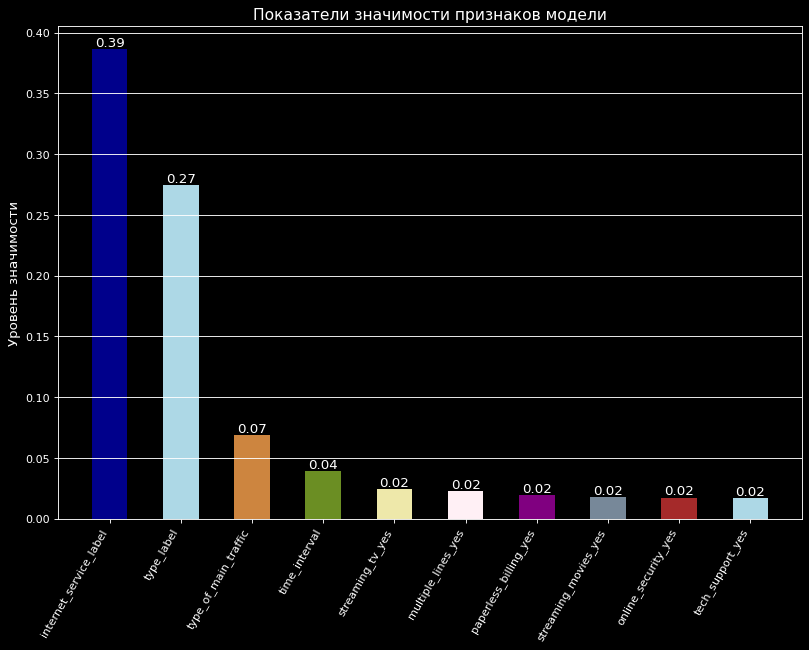

In [112]:
display(best_features_xgbc)
print()
bars_importance(best_features_xgbc)

Матрица ошибок лучшей модели:
 [[1217   49]
 [ 181  311]] 



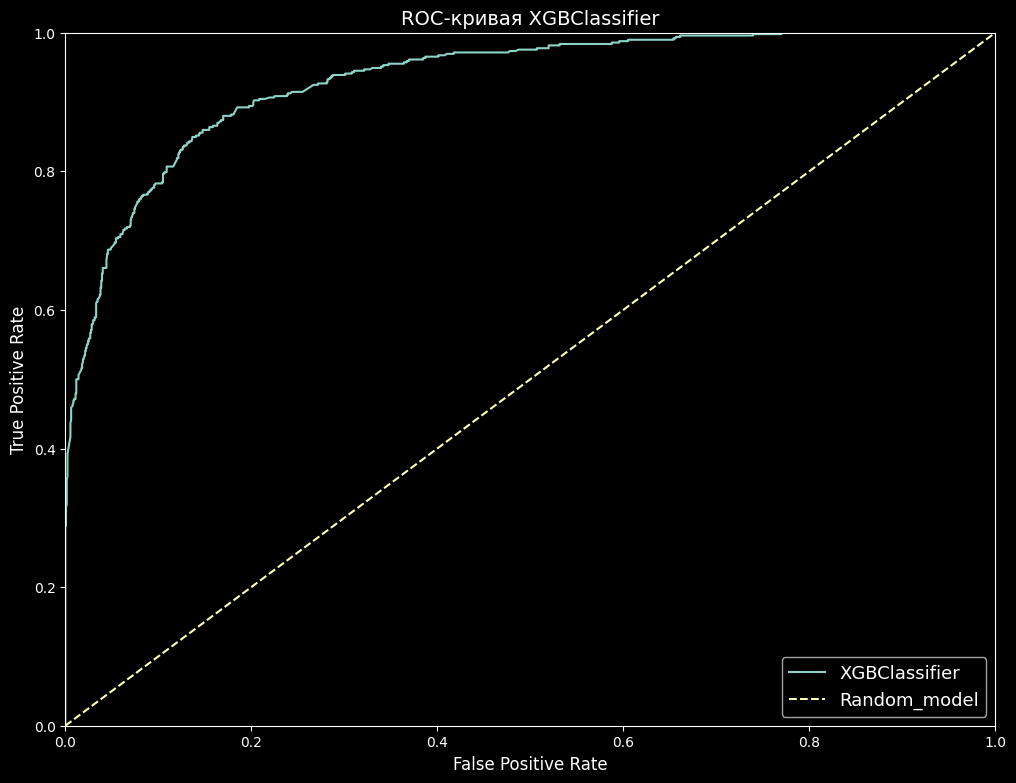

In [113]:
print('\033[4m\033[1m\033[31m{}\033[0m\n'
      .format('Матрица ошибок лучшей модели:'), matrix, '\n')

roc_curve_plot(best_model, best_model_name, features_xgbc)

---
**4. Сделали итоговый вывод**

---
Без труднойстей, конечно же, тоже не обошлось. Больше всего пришлось повозиться и подумать в исследовательском анализе и при отборе признаков. Для решения данных задач мы использвали различные инструменты:

* Разделяли группы на уже ушедших и оставшихся клиентов.
* С помощию средств библиотеки `matplotlib.pyplot` построили наглядные графики для визуализации признаков и распределений признаков (выводы по данному разделу приведены выше)
* С помощью feature_importance нашли самые важные фичи для построения наших моделей
* Кодировали категориальные признаки
* Изучали корреляцию категориальных и количественных признаков

По результату подготовки к моделированию и при построении моделей выяснили, что самыми важными признаками при построении модели мы смогли выделить time_interval (длительность клиентства), internet_service_label (способ подключения интернета), type_label (тип оплаты: ежемесячный, годовой) и monthly_charges (сумма ежемесячного платежа) (на самом деле их несколько больше, но самые важные будут именно эти).

По итогу наилучшим результатом обладает модель `XGBClassifier` на тестовой выборке - значение метрики ROC-AUC `0.875`.

---
**ИТОГ И РЕКОМЕНДАЦИИ ДЛЯ «Ниединогоразрыва.ком»**

1. Рекомендуем оператору проанализировать события конца 2019 года, где у произошёл большой обвал пользователей.

2. Провести анализ технической составляющей подключения пользователей интернета по современному оптическому волокну. Возможно, есть проблемы с поставляемым оптоволоконным кабелем или частыми повреждениями на магистральном канале.

3. Дополнительно необходим узкий анализ с опросом клиентов, потенциально готовых к переходу на оптическое волокно и обновлению интернет маршрутизаторов.

4. Сервисы стриминговое телевидение и доступ к каталогу фильмов нуждаются в доработке и сборе дополнительного фидбека, так как при своей заинтересованности клиентами они не способны удержать их, а возможно даже являются одной из неудовлетворительных причин оттока клиентов.

5. Следует рассмотреть вариант сезонных акций и скидок, привлекающих и подталкивающих людей оплатить услуги на большее время. Можно попробовать на тестовой группе решение с 3-х месячным и 6-м вариантом с логикой "Заплатил, забыл, оценил и продлил". 

6. Следует рассмотреть варианты оптимизации и привлекательности наиболее популярного способа оплаты услуг ерез электронные чеки;

7. Для прогнозированния оттока рекоменуем использовать модель XGBClassifier с параметрами:     
    - `max_depth`: 3,
    - `min_samples_split`: 0.2625708558380374, 
    - `n_estimators`: 155;